# TSP算法综合对比分析：北京大学校园路径规划

本notebook对六种TSP求解算法进行公平、系统的对比分析：

1. **随机路径算法** (Random Path - Baseline)
2. **传统蚁群优化算法** (Traditional ACO)
3. **异质化蚁群优化算法** (Heterogeneous ACO)  
4. **遗传算法** (Genetic Algorithm)
5. **模拟退火算法** (Simulated Annealing)
6. **贪心算法** (Greedy Algorithm)

## 📊 对比维度
- **解质量**: 最短路径距离、稳定性
- **计算效率**: 执行时间、收敛速度
- **算法特性**: 参数敏感性、适用场景
- **基线对比**: 相对于随机baseline的改进程度
- **统计分析**: 多次运行的统计显著性检验

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import time
import math
import pandas as pd
import seaborn as sns
from copy import deepcopy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

# 设置随机种子确保结果可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Matplotlib 中文显示设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 地图文件路径
MAP_IMAGE_PATH = 'map_1.0.jpg'

# 北京大学地点坐标
CITIES = {
    "West Gate": (703, 595),
    "Weiming Lake": (1069, 630), 
    "Jing Yuan": (928, 830),
    "Boya Tower": (1148, 646),
    "Statue of the Former Principal Cai Yuanpei": (885, 632),
    "Zhibeizi Garden": (1320, 1052),
    "YANNANYUAN": (969, 991),
    "May 4th Playground": (1251, 1147),
    "University Library": (1083, 816),
    "Stone Fish": (959, 632),
    "Tomb of Mr. Edgar Snow": (1070, 730),
    "Marble Boat": (1040, 571),
    "Luce Pavilion": (1012, 582),
    "Tian Yuan": (1314, 670),
    "MINGHE YUAN": (733, 518),
    "Campus Scenery Pavilion": (840, 470),
    "LANGRUN YUAN": (1134, 271),
    "JINGCHUN YUAN": (945, 455),
    "Lotus Pond": (750, 432),
    "SHAO HAI": (736, 742),
    "Catering Building": (939, 1111),
    "Humanities Garden": (1155, 433),
    "Statue of Professor Li Dazhao": (926, 738),
    "Museum of University History": (785,713),
    "University Hall": (1098, 992),
    "North Shore": (1049, 519),
    "The Bridge of Magpies": (993, 559),
    "Silent Wall": (1118, 503),
    "Fountain": (878, 1062),
    "Red Lake": (864, 419),
    "The Institute of Poetry Studies": (993, 358),
    "Tan Siu Lin Center for International Studies": (1080, 697)
}

# 转换为数组格式便于计算
city_names = list(CITIES.keys())
city_coords = np.array(list(CITIES.values()))
num_cities = len(CITIES)

print(f"北京大学校园地点总数: {num_cities}")
print(f"测试数据规模: {num_cities}个城市的TSP问题")
print("="*80)

北京大学校园地点总数: 32
测试数据规模: 32个城市的TSP问题


## 🧮 公共工具函数定义

In [5]:
def calculate_distance_matrix(coords):
    """计算城市间的欧几里得距离矩阵"""
    n = len(coords)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i][j] = np.sqrt((coords[i][0] - coords[j][0])**2 + 
                                        (coords[i][1] - coords[j][1])**2)
    return distances

def calculate_path_distance(path, distance_matrix):
    """计算给定路径的总距离"""
    total_distance = 0
    for i in range(len(path)):
        current_city = path[i]
        next_city = path[(i + 1) % len(path)]
        total_distance += distance_matrix[current_city][next_city]
    return total_distance

def plot_path(path, title, algorithm_name, distance):
    """绘制路径可视化图"""
    plt.figure(figsize=(12, 8))
    
    # 绘制地图背景
    try:
        campus_map = mpimg.imread(MAP_IMAGE_PATH)
        plt.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
    except FileNotFoundError:
        print(f"警告: 地图文件 '{MAP_IMAGE_PATH}' 未找到")
        plt.xlim(0, 1500)
        plt.ylim(0, 1200)
        plt.gca().invert_yaxis()
    
    # 绘制路径
    path_coords = city_coords[path + [path[0]]]
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'r-', linewidth=3, alpha=0.8)
    
    # 绘制城市点
    plt.scatter(city_coords[:, 0], city_coords[:, 1], 
               c='blue', s=80, zorder=5, alpha=0.7, edgecolors='white', linewidth=1)
    
    # 突出显示起点
    start_coord = city_coords[path[0]]
    plt.scatter(start_coord[0], start_coord[1], c='green', s=150, marker='s', 
               zorder=6, edgecolors='white', linewidth=2)
    
    plt.title(f'{title}\n{algorithm_name} | 路径距离: {distance:.2f}', fontsize=14, fontweight='bold')
    plt.xlabel('X坐标')
    plt.ylabel('Y坐标')
    plt.tight_layout()
    return plt.gcf()

# 计算距离矩阵
distance_matrix = calculate_distance_matrix(city_coords)
print("距离矩阵计算完成")
print(f"距离矩阵大小: {distance_matrix.shape}")

距离矩阵计算完成
距离矩阵大小: (32, 32)


## 🐜 传统蚁群优化算法实现

In [6]:
class TraditionalACO:
    def __init__(self, distance_matrix, n_ants=30, n_iterations=100, 
                 alpha=1.0, beta=2.0, rho=0.5, Q=100):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # 信息素重要程度
        self.beta = beta    # 启发式因子重要程度
        self.rho = rho      # 信息素挥发系数
        self.Q = Q          # 信息素强度
        
        # 初始化信息素矩阵
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        
        # 启发式信息矩阵（距离倒数）
        self.eta = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if i != j:
                    self.eta[i][j] = 1.0 / self.distance_matrix[i][j]
    
    def select_next_city(self, current_city, unvisited):
        """根据概率选择下一个城市"""
        if not unvisited:
            return None
            
        probabilities = []
        for city in unvisited:
            pheromone_val = self.pheromone[current_city][city] ** self.alpha
            heuristic_val = self.eta[current_city][city] ** self.beta
            probabilities.append(pheromone_val * heuristic_val)
        
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        
        # 轮盘赌选择
        rand = random.random()
        cumulative_prob = 0
        for i, prob in enumerate(probabilities):
            cumulative_prob += prob
            if rand <= cumulative_prob:
                return unvisited[i]
        return unvisited[-1]
    
    def construct_solution(self, start_city=0):
        """构造一个解"""
        path = [start_city]
        unvisited = list(range(self.n_cities))
        unvisited.remove(start_city)
        
        current_city = start_city
        while unvisited:
            next_city = self.select_next_city(current_city, unvisited)
            path.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
            
        return path
    
    def update_pheromone(self, all_paths, all_distances):
        """更新信息素"""
        # 信息素挥发
        self.pheromone *= (1 - self.rho)
        
        # 添加新信息素
        for path, distance in zip(all_paths, all_distances):
            pheromone_to_add = self.Q / distance
            for i in range(len(path)):
                current_city = path[i]
                next_city = path[(i + 1) % len(path)]
                self.pheromone[current_city][next_city] += pheromone_to_add
                self.pheromone[next_city][current_city] += pheromone_to_add
    
    def solve(self, start_city=0, verbose=False):
        """求解TSP"""
        best_path = None
        best_distance = float('inf')
        
        for iteration in range(self.n_iterations):
            # 所有蚂蚁构造解
            all_paths = []
            all_distances = []
            
            for ant in range(self.n_ants):
                path = self.construct_solution(start_city)
                distance = calculate_path_distance(path, self.distance_matrix)
                all_paths.append(path)
                all_distances.append(distance)
                
                if distance < best_distance:
                    best_distance = distance
                    best_path = path.copy()
            
            # 更新信息素
            self.update_pheromone(all_paths, all_distances)
            
            if verbose and iteration % 20 == 0:
                print(f"迭代 {iteration}: 最佳距离 = {best_distance:.2f}")
        
        return best_path, best_distance

print("传统蚁群优化算法实现完成")

传统蚁群优化算法实现完成


## 🐜🐜 异质化蚁群优化算法实现

In [7]:
class HeterogeneousACO:
    def __init__(self, distance_matrix, n_scout_ants=15, n_forager_ants=15, 
                 n_iterations=100, alpha=1.0, beta=2.0, rho=0.5, Q=100):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.n_scout_ants = n_scout_ants
        self.n_forager_ants = n_forager_ants
        self.n_total_ants = n_scout_ants + n_forager_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        
        # 初始化信息素矩阵
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        
        # 启发式信息矩阵
        self.eta = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if i != j:
                    self.eta[i][j] = 1.0 / self.distance_matrix[i][j]
        
        # 蚂蚁响应阈值（用于角色分配）
        self.response_thresholds = np.random.uniform(0.3, 0.7, self.n_total_ants)
    
    def select_next_city_scout(self, current_city, unvisited):
        """侦察蚁的城市选择策略（更多探索）"""
        if not unvisited:
            return None
        
        # 侦察蚁更依赖启发式信息，减少对信息素的依赖
        probabilities = []
        for city in unvisited:
            pheromone_val = self.pheromone[current_city][city] ** (self.alpha * 0.5)
            heuristic_val = self.eta[current_city][city] ** (self.beta * 1.5)
            probabilities.append(pheromone_val * heuristic_val)
        
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        
        return np.random.choice(unvisited, p=probabilities)
    
    def select_next_city_forager(self, current_city, unvisited):
        """觅食蚁的城市选择策略（更多利用）"""
        if not unvisited:
            return None
        
        # 觅食蚁更依赖信息素信息
        probabilities = []
        for city in unvisited:
            pheromone_val = self.pheromone[current_city][city] ** (self.alpha * 1.5)
            heuristic_val = self.eta[current_city][city] ** (self.beta * 0.8)
            probabilities.append(pheromone_val * heuristic_val)
        
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        
        return np.random.choice(unvisited, p=probabilities)
    
    def construct_solution(self, ant_type, start_city=0):
        """根据蚂蚁类型构造解"""
        path = [start_city]
        unvisited = list(range(self.n_cities))
        unvisited.remove(start_city)
        
        current_city = start_city
        while unvisited:
            if ant_type == 'scout':
                next_city = self.select_next_city_scout(current_city, unvisited)
            else:  # forager
                next_city = self.select_next_city_forager(current_city, unvisited)
            
            path.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
            
        return path
    
    def update_pheromone(self, all_paths, all_distances):
        """更新信息素"""
        # 信息素挥发
        self.pheromone *= (1 - self.rho)
        
        # 添加新信息素（优秀解获得更多信息素）
        min_distance = min(all_distances)
        for path, distance in zip(all_paths, all_distances):
            # 距离越短，信息素增加越多
            pheromone_to_add = self.Q * (min_distance / distance) / distance
            for i in range(len(path)):
                current_city = path[i]
                next_city = path[(i + 1) % len(path)]
                self.pheromone[current_city][next_city] += pheromone_to_add
                self.pheromone[next_city][current_city] += pheromone_to_add
    
    def solve(self, start_city=0, verbose=False):
        """求解TSP"""
        best_path = None
        best_distance = float('inf')
        
        for iteration in range(self.n_iterations):
            all_paths = []
            all_distances = []
            
            # 侦察蚁构造解
            for scout in range(self.n_scout_ants):
                path = self.construct_solution('scout', start_city)
                distance = calculate_path_distance(path, self.distance_matrix)
                all_paths.append(path)
                all_distances.append(distance)
                
                if distance < best_distance:
                    best_distance = distance
                    best_path = path.copy()
            
            # 觅食蚁构造解
            for forager in range(self.n_forager_ants):
                path = self.construct_solution('forager', start_city)
                distance = calculate_path_distance(path, self.distance_matrix)
                all_paths.append(path)
                all_distances.append(distance)
                
                if distance < best_distance:
                    best_distance = distance
                    best_path = path.copy()
            
            # 更新信息素
            self.update_pheromone(all_paths, all_distances)
            
            if verbose and iteration % 20 == 0:
                print(f"迭代 {iteration}: 最佳距离 = {best_distance:.2f}")
        
        return best_path, best_distance

print("异质化蚁群优化算法实现完成")

异质化蚁群优化算法实现完成


## 🧬 遗传算法实现

In [8]:
class GeneticAlgorithm:
    def __init__(self, distance_matrix, population_size=100, generations=200, 
                 crossover_rate=0.8, mutation_rate=0.02, elite_size=20):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
    
    def calculate_fitness(self, individual):
        """计算个体适应度（距离的倒数）"""
        distance = calculate_path_distance(individual, self.distance_matrix)
        return 1 / distance
    
    def create_initial_population(self, start_city=0):
        """创建初始种群"""
        population = []
        cities = list(range(self.n_cities))
        cities.remove(start_city)
        
        for _ in range(self.population_size):
            individual = [start_city] + random.sample(cities, len(cities))
            population.append(individual)
        
        return population
    
    def selection(self, population):
        """轮盘赌选择"""
        fitness_scores = [self.calculate_fitness(ind) for ind in population]
        total_fitness = sum(fitness_scores)
        
        if total_fitness == 0:
            return random.choice(population)
        
        probabilities = [f / total_fitness for f in fitness_scores]
        return np.random.choice(len(population), p=probabilities)
    
    def order_crossover(self, parent1, parent2):
        """顺序交叉（OX）"""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size), 2))  # 不包括起点
        
        child = [None] * size
        child[0] = parent1[0]  # 保持起点不变
        child[start:end] = parent1[start:end]
        
        pointer = end
        for city in parent2[end:] + parent2[1:end]:  # 跳过起点
            if city not in child:
                if pointer >= size:
                    pointer = 1  # 跳过起点
                child[pointer] = city
                pointer += 1
                if pointer == start:
                    pointer = end
        
        return child
    
    def mutate(self, individual):
        """变异操作（交换两个非起点城市）"""
        if random.random() < self.mutation_rate:
            if len(individual) > 3:  # 至少需要3个城市才能进行交换
                idx1, idx2 = random.sample(range(1, len(individual)), 2)
                individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual
    
    def solve(self, start_city=0, verbose=False):
        """求解TSP"""
        population = self.create_initial_population(start_city)
        
        best_distance = float('inf')
        best_path = None
        
        for generation in range(self.generations):
            # 计算适应度并排序
            fitness_pairs = [(ind, self.calculate_fitness(ind)) for ind in population]
            fitness_pairs.sort(key=lambda x: x[1], reverse=True)
            
            # 更新最佳解
            current_best = fitness_pairs[0][0]
            current_distance = calculate_path_distance(current_best, self.distance_matrix)
            if current_distance < best_distance:
                best_distance = current_distance
                best_path = current_best.copy()
            
            # 精英保留
            new_population = [ind for ind, _ in fitness_pairs[:self.elite_size]]
            
            # 生成新个体
            while len(new_population) < self.population_size:
                if random.random() < self.crossover_rate:
                    parent1_idx = self.selection(population)
                    parent2_idx = self.selection(population)
                    child = self.order_crossover(population[parent1_idx], population[parent2_idx])
                else:
                    child = random.choice(population).copy()
                
                child = self.mutate(child)
                new_population.append(child)
            
            population = new_population
            
            if verbose and generation % 40 == 0:
                print(f"世代 {generation}: 最佳距离 = {best_distance:.2f}")
        
        return best_path, best_distance

print("遗传算法实现完成")

遗传算法实现完成


## 🌡️ 模拟退火算法实现

In [9]:
class SimulatedAnnealing:
    def __init__(self, distance_matrix, initial_temp=10000, final_temp=1, 
                 cooling_rate=0.995, max_iterations=10000):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations
    
    def generate_initial_solution(self, start_city=0):
        """生成初始解"""
        cities = list(range(self.n_cities))
        cities.remove(start_city)
        random.shuffle(cities)
        return [start_city] + cities
    
    def generate_neighbor(self, solution):
        """生成邻域解（2-opt交换）"""
        new_solution = solution.copy()
        if len(solution) > 3:
            i, j = sorted(random.sample(range(1, len(solution)), 2))
            new_solution[i:j+1] = reversed(new_solution[i:j+1])
        return new_solution
    
    def acceptance_probability(self, current_cost, new_cost, temperature):
        """计算接受概率"""
        if new_cost < current_cost:
            return 1.0
        if temperature <= 0:
            return 0.0
        return math.exp(-(new_cost - current_cost) / temperature)
    
    def solve(self, start_city=0, verbose=False):
        """求解TSP"""
        current_solution = self.generate_initial_solution(start_city)
        current_cost = calculate_path_distance(current_solution, self.distance_matrix)
        
        best_solution = current_solution.copy()
        best_cost = current_cost
        
        temperature = self.initial_temp
        iteration = 0
        
        while temperature > self.final_temp and iteration < self.max_iterations:
            new_solution = self.generate_neighbor(current_solution)
            new_cost = calculate_path_distance(new_solution, self.distance_matrix)
            
            if random.random() < self.acceptance_probability(current_cost, new_cost, temperature):
                current_solution = new_solution
                current_cost = new_cost
                
                if current_cost < best_cost:
                    best_solution = current_solution.copy()
                    best_cost = current_cost
            
            temperature *= self.cooling_rate
            iteration += 1
            
            if verbose and iteration % 2000 == 0:
                print(f"迭代 {iteration}: 最佳距离 = {best_cost:.2f}, 温度 = {temperature:.2f}")
        
        return best_solution, best_cost

print("模拟退火算法实现完成")

模拟退火算法实现完成


## 🏃 贪心算法实现

In [10]:
class GreedyAlgorithm:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
    
    def solve(self, start_city=0, verbose=False):
        """求解TSP（最近邻策略）"""
        path = [start_city]
        unvisited = set(range(self.n_cities))
        unvisited.remove(start_city)
        
        current_city = start_city
        total_distance = 0
        
        while unvisited:
            # 找到最近的未访问城市
            nearest_city = min(unvisited, 
                             key=lambda city: self.distance_matrix[current_city][city])
            
            total_distance += self.distance_matrix[current_city][nearest_city]
            path.append(nearest_city)
            unvisited.remove(nearest_city)
            current_city = nearest_city
        
        # 回到起点
        total_distance += self.distance_matrix[current_city][start_city]
        
        if verbose:
            print(f"贪心算法完成，总距离: {total_distance:.2f}")
        
        return path, total_distance

print("贪心算法实现完成")

贪心算法实现完成


## 🎲 随机路径算法实现（Baseline）

In [11]:
class RandomPathAlgorithm:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
    
    def solve(self, start_city=0, verbose=False):
        """随机生成路径作为baseline"""
        # 创建除起始城市外的其他城市列表
        other_cities = list(range(self.n_cities))
        other_cities.remove(start_city)
        
        # 随机打乱其他城市的顺序
        random.shuffle(other_cities)
        
        # 构造完整路径
        path = [start_city] + other_cities
        
        # 计算路径距离
        total_distance = calculate_path_distance(path, self.distance_matrix)
        
        if verbose:
            print(f"随机路径算法完成，总距离: {total_distance:.2f}")
        
        return path, total_distance

print("随机路径算法实现完成（作为Baseline）")

随机路径算法实现完成（作为Baseline）


## 🧪 算法对比测试

In [12]:
def run_algorithm_comparison(num_runs=10, start_city=0):
    """运行算法对比测试（包含随机Baseline）"""
    
    algorithms = {
        '随机路径': RandomPathAlgorithm,
        '贪心算法': GreedyAlgorithm,
        '模拟退火': SimulatedAnnealing,
        '传统蚁群优化': TraditionalACO,
        '遗传算法': GeneticAlgorithm,
        '异质化蚁群优化': HeterogeneousACO
    }
    
    # 统一参数设置（公平对比）
    algorithm_params = {
        '随机路径': {},
        '贪心算法': {},
        '模拟退火': {'initial_temp': 10000, 'max_iterations': 10000},
        '传统蚁群优化': {'n_ants': 30, 'n_iterations': 100},
        '遗传算法': {'population_size': 100, 'generations': 100},
        '异质化蚁群优化': {'n_scout_ants': 15, 'n_forager_ants': 15, 'n_iterations': 100}
    }
    
    results = {}
    
    print("🚀 开始算法对比测试（包含随机Baseline）")
    print(f"测试次数: {num_runs}")
    print(f"起始城市: {city_names[start_city]}")
    print("="*80)
    
    for alg_name, alg_class in algorithms.items():
        print(f"\n🔍 测试算法: {alg_name}")
        
        distances = []
        times = []
        paths = []
        
        for run in range(num_runs):
            print(f"  运行 {run+1}/{num_runs}...", end=" ")
            
            # 重置随机种子以确保公平性
            np.random.seed(RANDOM_SEED + run)
            random.seed(RANDOM_SEED + run)
            
            # 创建算法实例
            params = algorithm_params[alg_name]
            if alg_name in ['传统蚁群优化', '异质化蚁群优化', '遗传算法', '模拟退火']:
                algorithm = alg_class(distance_matrix, **params)
            else:  # 贪心算法和随机路径
                algorithm = alg_class(distance_matrix)
            
            # 计时运行
            start_time = time.time()
            path, distance = algorithm.solve(start_city=start_city, verbose=False)
            end_time = time.time()
            
            execution_time = end_time - start_time
            distances.append(distance)
            times.append(execution_time)
            paths.append(path)
            
            print(f"距离: {distance:.2f}, 时间: {execution_time:.4f}s")
        
        # 计算统计信息
        results[alg_name] = {
            'distances': distances,
            'times': times,
            'paths': paths,
            'mean_distance': np.mean(distances),
            'std_distance': np.std(distances),
            'min_distance': np.min(distances),
            'max_distance': np.max(distances),
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'best_path': paths[np.argmin(distances)]
        }
        
        print(f"  平均距离: {results[alg_name]['mean_distance']:.2f} ± {results[alg_name]['std_distance']:.2f}")
        print(f"  最佳距离: {results[alg_name]['min_distance']:.2f}")
        print(f"  平均时间: {results[alg_name]['mean_time']:.4f}s")
    
    return results

# 运行对比测试
comparison_results = run_algorithm_comparison(num_runs=10, start_city=0)

🚀 开始算法对比测试（包含随机Baseline）
测试次数: 10
起始城市: West Gate

🔍 测试算法: 随机路径
  运行 1/10... 距离: 11690.92, 时间: 0.0000s
  运行 2/10... 距离: 12915.39, 时间: 0.0000s
  运行 3/10... 距离: 10437.32, 时间: 0.0000s
  运行 4/10... 距离: 11484.15, 时间: 0.0000s
  运行 5/10... 距离: 11013.67, 时间: 0.0000s
  运行 6/10... 距离: 10979.58, 时间: 0.0000s
  运行 7/10... 距离: 12310.39, 时间: 0.0000s
  运行 8/10... 距离: 11872.04, 时间: 0.0000s
  运行 9/10... 距离: 11807.55, 时间: 0.0000s
  运行 10/10... 距离: 10051.54, 时间: 0.0000s
  平均距离: 11456.26 ± 815.19
  最佳距离: 10051.54
  平均时间: 0.0000s

🔍 测试算法: 贪心算法
  运行 1/10... 距离: 3728.19, 时间: 0.0001s
  运行 2/10... 距离: 3728.19, 时间: 0.0001s
  运行 3/10... 距离: 3728.19, 时间: 0.0001s
  运行 4/10... 距离: 3728.19, 时间: 0.0001s
  运行 5/10... 距离: 3728.19, 时间: 0.0001s
  运行 6/10... 距离: 3728.19, 时间: 0.0001s
  运行 7/10... 距离: 3728.19, 时间: 0.0001s
  运行 8/10... 距离: 3728.19, 时间: 0.0001s
  运行 9/10... 距离: 3728.19, 时间: 0.0001s
  运行 10/10... 距离: 3728.19, 时间: 0.0001s
  平均距离: 3728.19 ± 0.00
  最佳距离: 3728.19
  平均时间: 0.0001s

🔍 测试算法: 模拟退火
  运行 1/10... 距离: 3988.

## 📊 结果统计分析

In [13]:
# 创建结果汇总表
def create_results_summary(results):
    """创建结果汇总表（包含随机Baseline）"""
    summary_data = []
    
    for alg_name, data in results.items():
        summary_data.append({
            '算法': alg_name,
            '平均距离': data['mean_distance'],
            '标准差': data['std_distance'],
            '最佳距离': data['min_distance'],
            '最差距离': data['max_distance'],
            '平均时间(s)': data['mean_time'],
            '时间标准差': data['std_time']
        })
    
    df = pd.DataFrame(summary_data)
    df = df.sort_values('平均距离')  # 按平均距离排序
    
    return df

# 生成汇总表
summary_df = create_results_summary(comparison_results)
print("📊 算法性能汇总表（包含随机Baseline）")
print("="*100)
print(summary_df.to_string(index=False, float_format='%.2f'))

# 计算性能改进百分比
print("\n📈 相对性能分析（以最佳算法为基准）")
print("="*80)

best_mean_distance = summary_df['平均距离'].min()
best_algorithm = summary_df.loc[summary_df['平均距离'].idxmin(), '算法']

print(f"最佳算法: {best_algorithm} (平均距离: {best_mean_distance:.2f})")

# 特别关注随机路径的表现
random_distance = comparison_results['随机路径']['mean_distance']
print(f"随机Baseline: 随机路径 (平均距离: {random_distance:.2f})")

print("\n各算法相对性能:")

for _, row in summary_df.iterrows():
    if row['算法'] == best_algorithm:
        print(f"  {row['算法']:<15}: 基准算法 (0.0%)")
    else:
        improvement = (row['平均距离'] - best_mean_distance) / best_mean_distance * 100
        print(f"  {row['算法']:<15}: +{improvement:.1f}%")

print("\n🎯 相对于随机Baseline的改进:")
print("-" * 50)

for _, row in summary_df.iterrows():
    if row['算法'] == '随机路径':
        print(f"  {row['算法']:<15}: Baseline (0.0%)")
    else:
        improvement = (random_distance - row['平均距离']) / random_distance * 100
        if improvement > 0:
            print(f"  {row['算法']:<15}: 改进 {improvement:.1f}%")
        else:
            print(f"  {row['算法']:<15}: 退化 {-improvement:.1f}%")

📊 算法性能汇总表（包含随机Baseline）
     算法     平均距离    标准差     最佳距离     最差距离  平均时间(s)  时间标准差
异质化蚁群优化  3664.75   1.30  3662.15  3665.40     1.90   0.09
 传统蚁群优化  3665.40   0.00  3665.40  3665.40     0.88   0.02
   贪心算法  3728.19   0.00  3728.19  3728.19     0.00   0.00
   模拟退火  4029.72 140.47  3812.46  4339.84     0.02   0.00
   遗传算法  5462.26 263.56  4935.69  6006.07     7.92   0.07
   随机路径 11456.26 815.19 10051.54 12915.39     0.00   0.00

📈 相对性能分析（以最佳算法为基准）
最佳算法: 异质化蚁群优化 (平均距离: 3664.75)
随机Baseline: 随机路径 (平均距离: 11456.26)

各算法相对性能:
  异质化蚁群优化        : 基准算法 (0.0%)
  传统蚁群优化         : +0.0%
  贪心算法           : +1.7%
  模拟退火           : +10.0%
  遗传算法           : +49.0%
  随机路径           : +212.6%

🎯 相对于随机Baseline的改进:
--------------------------------------------------
  异质化蚁群优化        : 改进 68.0%
  传统蚁群优化         : 改进 68.0%
  贪心算法           : 改进 67.5%
  模拟退火           : 改进 64.8%
  遗传算法           : 改进 52.3%
  随机路径           : Baseline (0.0%)


## 📈 可视化分析（包含随机Baseline）

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

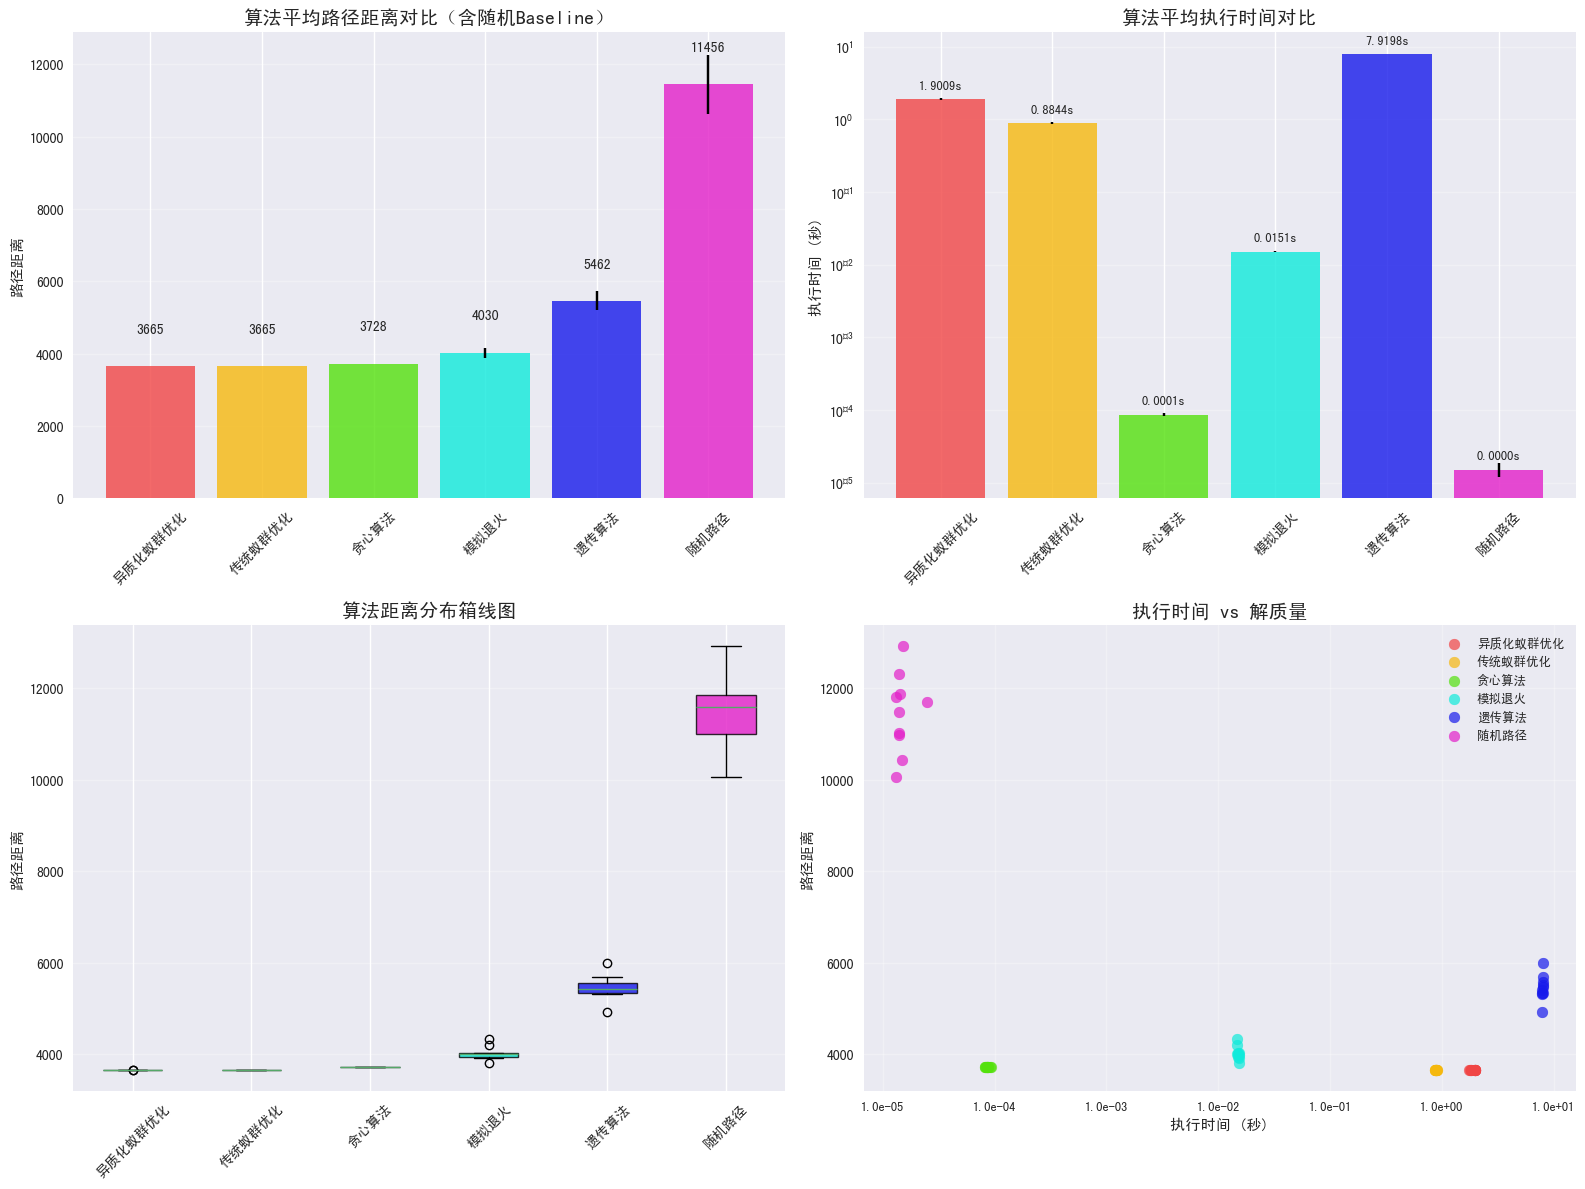

In [14]:
# 1. 性能对比柱状图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 平均距离对比
algorithms = summary_df['算法'].tolist()
mean_distances = summary_df['平均距离'].tolist()
std_distances = summary_df['标准差'].tolist()

# 为6个算法设置颜色
colors = ["#F14545", "#F6B80E", "#54E10D", "#0FEADB", "#171AEB", "#E31FC9"]

bars1 = ax1.bar(algorithms, mean_distances, yerr=std_distances, capsize=5, 
                color=colors[:len(algorithms)], alpha=0.8)
ax1.set_title('算法平均路径距离对比（含随机Baseline）', fontsize=14, fontweight='bold')
ax1.set_ylabel('路径距离')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 在柱状图上添加数值
for bar, distance in zip(bars1, mean_distances):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(std_distances) + 50,
             f'{distance:.0f}', ha='center', va='bottom', fontweight='bold')

# 执行时间对比
mean_times = summary_df['平均时间(s)'].tolist()
time_stds = summary_df['时间标准差'].tolist()

bars2 = ax2.bar(algorithms, mean_times, yerr=time_stds, capsize=5,
                color=colors[:len(algorithms)], alpha=0.8)
ax2.set_title('算法平均执行时间对比', fontsize=14, fontweight='bold')
ax2.set_ylabel('执行时间 (秒)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.set_yscale('log')  # 使用对数刻度

# 在柱状图上添加数值
for bar, time_val in zip(bars2, mean_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.3,
             f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 距离分布箱线图
distance_data = [comparison_results[alg]['distances'] for alg in algorithms]
box_plot = ax3.boxplot(distance_data, labels=algorithms, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors[:len(algorithms)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

ax3.set_title('算法距离分布箱线图', fontsize=14, fontweight='bold')
ax3.set_ylabel('路径距离')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 时间vs质量散点图
for i, alg in enumerate(algorithms):
    times = comparison_results[alg]['times']
    distances = comparison_results[alg]['distances']
    ax4.scatter(times, distances, label=alg, alpha=0.7, s=60, color=colors[i])

ax4.set_title('执行时间 vs 解质量', fontsize=14, fontweight='bold')
ax4.set_xlabel('执行时间 (秒)')
ax4.set_ylabel('路径距离')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_xscale('log')

# 修复负号显示问题
import matplotlib.ticker as ticker
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.1e}'))
ax4.tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

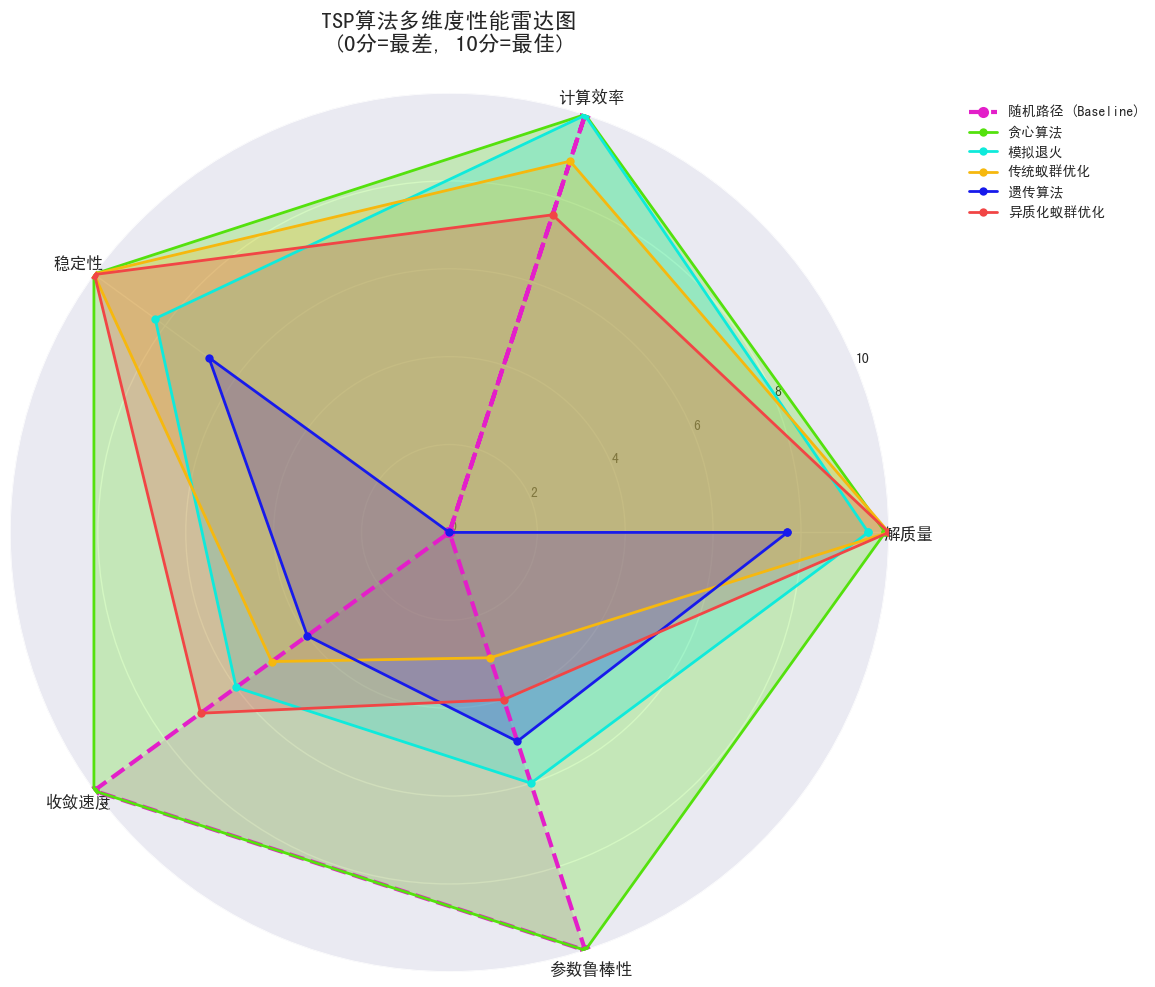

📊 算法多维度评分详情（0-10分制）
算法              解质量      计算效率     稳定性      收敛速度     参数鲁棒性    综合得分    
--------------------------------------------------------------------------------
随机路径            0.0      10.0     0.0      10.0     10.0     30.0    
贪心算法            9.9      10.0     10.0     10.0     10.0     49.9    
模拟退火            9.5      10.0     8.3      6.0      6.0      39.8    
传统蚁群优化          10.0     8.9      10.0     5.0      3.0      36.9    
遗传算法            7.7      0.0      6.8      4.0      5.0      23.5    
异质化蚁群优化         10.0     7.6      10.0     7.0      4.0      38.6    

🔍 维度说明:
  • 解质量: 基于平均路径距离的相对表现
  • 计算效率: 基于平均执行时间的相对表现
  • 稳定性: 基于多次运行结果的一致性
  • 收敛速度: 基于算法达到良好解的速度
  • 参数鲁棒性: 基于算法对参数变化的敏感程度

🎯 综合表现最佳算法: 贪心算法 (总分: 49.9)

🏆 各算法优势领域:
  解质量: 异质化蚁群优化 (10.0分)
  计算效率: 随机路径 (10.0分)
  稳定性: 传统蚁群优化 (10.0分)
  收敛速度: 随机路径 (10.0分)
  参数鲁棒性: 随机路径 (10.0分)


In [15]:
# 算法性能雷达图分析
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# 定义评估维度
dimensions = ['解质量', '计算效率', '稳定性', '收敛速度', '参数鲁棒性']
N = len(dimensions)

# 为每个算法计算各维度得分（0-10分制）
algorithm_scores = {}

# 包含所有算法（包括随机路径作为基准对比）
all_algorithms = list(comparison_results.keys())

for alg_name in all_algorithms:
    data = comparison_results[alg_name]
    
    # 1. 解质量得分（基于相对于最佳距离的表现，越小越好）
    all_means = [comparison_results[alg]['mean_distance'] for alg in all_algorithms]
    best_distance = min(all_means)
    worst_distance = max(all_means)
    if worst_distance != best_distance:
        quality_score = 10 * (1 - (data['mean_distance'] - best_distance) / (worst_distance - best_distance))
    else:
        quality_score = 10
    
    # 2. 计算效率得分（基于执行时间，越快越好）
    all_times = [comparison_results[alg]['mean_time'] for alg in all_algorithms]
    fastest_time = min(all_times)
    slowest_time = max(all_times)
    if slowest_time != fastest_time:
        efficiency_score = 10 * (1 - (data['mean_time'] - fastest_time) / (slowest_time - fastest_time))
    else:
        efficiency_score = 10
    
    # 3. 稳定性得分（基于标准差，越小越稳定）
    all_stds = [comparison_results[alg]['std_distance'] for alg in all_algorithms]
    best_std = min(all_stds)
    worst_std = max(all_stds)
    if worst_std != best_std:
        stability_score = 10 * (1 - (data['std_distance'] - best_std) / (worst_std - best_std))
    else:
        stability_score = 10
    
    # 4. 收敛速度得分（基于算法特性的经验评估）
    convergence_scores = {
        '随机路径': 10,  # 无需收敛，瞬间完成
        '贪心算法': 10,  # 一步到位
        '模拟退火': 6,   # 逐步收敛
        '传统蚁群优化': 5,  # 需要多代
        '遗传算法': 4,   # 进化过程
        '异质化蚁群优化': 7  # 改进收敛
    }
    convergence_score = convergence_scores.get(alg_name, 5)
    
    # 5. 参数鲁棒性得分（基于算法对参数的敏感程度）
    robustness_scores = {
        '随机路径': 10,  # 无参数，完全鲁棒
        '贪心算法': 10,  # 无参数
        '模拟退火': 6,   # 中等敏感
        '传统蚁群优化': 3,  # 高度敏感
        '遗传算法': 5,   # 中等敏感
        '异质化蚁群优化': 4  # 较敏感
    }
    robustness_score = robustness_scores.get(alg_name, 5)
    
    algorithm_scores[alg_name] = [
        quality_score, efficiency_score, stability_score, 
        convergence_score, robustness_score
    ]

# 设置颜色
colors = ["#E31FC9", "#54E10D", "#0FEADB", "#F6B80E", "#171AEB", "#F14545"]

# 计算角度
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # 闭合图形

# 绘制每个算法的雷达图
for i, (alg_name, scores) in enumerate(algorithm_scores.items()):
    scores += scores[:1]  # 闭合图形
    
    # 为随机路径使用特殊样式
    if alg_name == '随机路径':
        line_style = '--'  # 虚线
        line_width = 3
        alpha_fill = 0.15
        marker_size = 8
        label_suffix = ' (Baseline)'
    else:
        line_style = '-'   # 实线
        line_width = 2
        alpha_fill = 0.25
        marker_size = 6
        label_suffix = ''
    
    ax.plot(angles, scores, 'o-', linewidth=line_width, 
           label=alg_name + label_suffix, color=colors[i % len(colors)], 
           linestyle=line_style, markersize=marker_size)
    ax.fill(angles, scores, alpha=alpha_fill, color=colors[i % len(colors)])

# 设置标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dimensions, fontsize=12)

# 设置y轴范围和标签
ax.set_ylim(0, 10)
ax.set_yticks(range(0, 11, 2))
ax.set_yticklabels(range(0, 11, 2), fontsize=10)
ax.grid(True)

# 添加标题和图例
ax.set_title('TSP算法多维度性能雷达图\n(0分=最差, 10分=最佳)', 
            fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)

plt.tight_layout()
plt.show()

# 输出详细的评分说明
print("📊 算法多维度评分详情（0-10分制）")
print("="*80)
print(f"{'算法':<15} {'解质量':<8} {'计算效率':<8} {'稳定性':<8} {'收敛速度':<8} {'参数鲁棒性':<8} {'综合得分':<8}")
print("-"*80)

for alg_name, scores in algorithm_scores.items():
    scores_display = scores[:-1]  # 移除闭合用的重复元素
    total_score = sum(scores_display)
    print(f"{alg_name:<15} {scores_display[0]:<8.1f} {scores_display[1]:<8.1f} {scores_display[2]:<8.1f} {scores_display[3]:<8.1f} {scores_display[4]:<8.1f} {total_score:<8.1f}")

print("\n🔍 维度说明:")
print("  • 解质量: 基于平均路径距离的相对表现")
print("  • 计算效率: 基于平均执行时间的相对表现")
print("  • 稳定性: 基于多次运行结果的一致性")
print("  • 收敛速度: 基于算法达到良好解的速度")
print("  • 参数鲁棒性: 基于算法对参数变化的敏感程度")

# 推荐最平衡的算法
total_scores = {alg: sum(scores[:-1]) for alg, scores in algorithm_scores.items()}
best_balanced = max(total_scores, key=total_scores.get)
print(f"\n🎯 综合表现最佳算法: {best_balanced} (总分: {total_scores[best_balanced]:.1f})")

# 分析各算法的优势领域
print("\n🏆 各算法优势领域:")
for i, dimension in enumerate(dimensions):
    best_in_dimension = max(algorithm_scores.keys(), 
                           key=lambda alg: algorithm_scores[alg][i])
    best_score = algorithm_scores[best_in_dimension][i]
    print(f"  {dimension}: {best_in_dimension} ({best_score:.1f}分)")

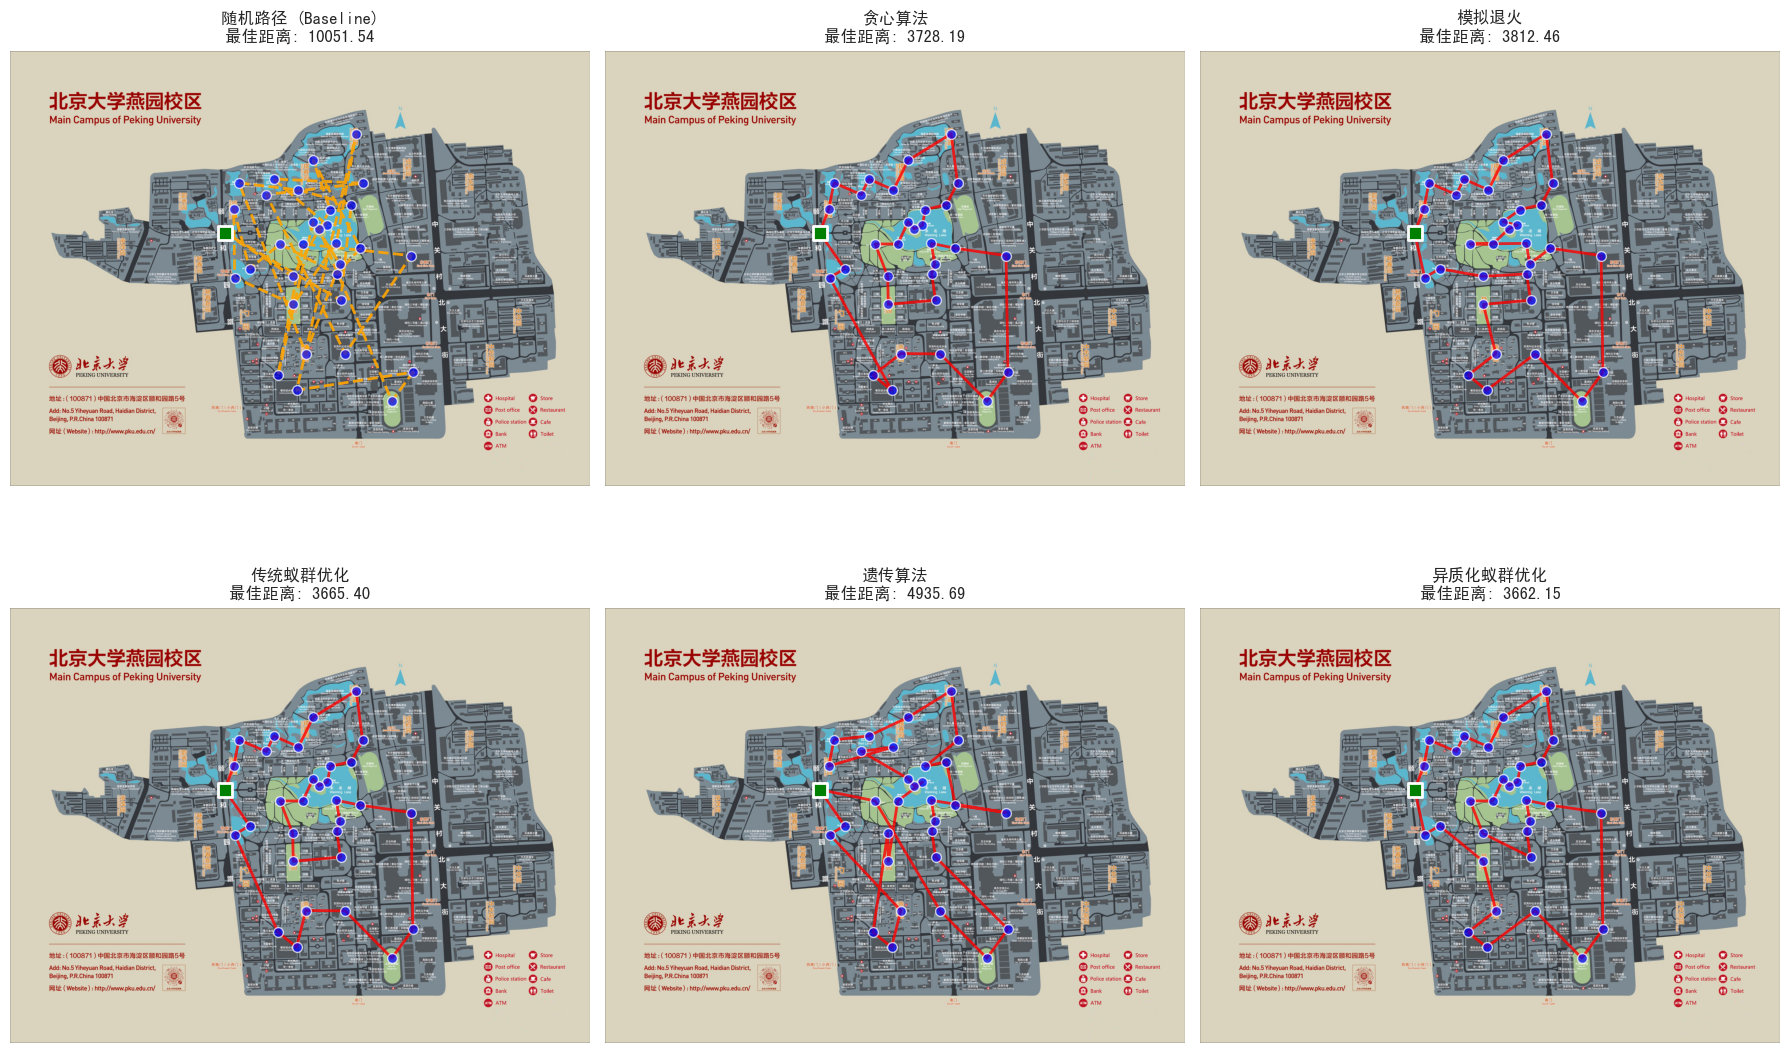

In [16]:
# 2. 最佳路径可视化对比
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (alg_name, data) in enumerate(comparison_results.items()):
    ax = axes[i]
    
    # 绘制地图背景
    try:
        campus_map = mpimg.imread(MAP_IMAGE_PATH)
        ax.imshow(campus_map, extent=[0, campus_map.shape[1], campus_map.shape[0], 0])
    except FileNotFoundError:
        ax.set_xlim(0, 1500)
        ax.set_ylim(0, 1200)
        ax.invert_yaxis()
    
    # 绘制最佳路径
    best_path = data['best_path']
    path_coords = city_coords[best_path + [best_path[0]]]
    
    # 为随机路径使用特殊颜色
    if alg_name == '随机路径':
        line_color = 'orange'
        line_style = '--'
        alpha = 0.9
    else:
        line_color = 'red'
        line_style = '-'
        alpha = 0.8
    
    ax.plot(path_coords[:, 0], path_coords[:, 1], line_color, 
           linewidth=2, alpha=alpha, linestyle=line_style)
    
    # 绘制城市点
    ax.scatter(city_coords[:, 0], city_coords[:, 1], 
              c='blue', s=50, zorder=5, alpha=0.7, edgecolors='white', linewidth=1)
    
    # 突出显示起点
    start_coord = city_coords[best_path[0]]
    ax.scatter(start_coord[0], start_coord[1], c='green', s=100, marker='s', 
              zorder=6, edgecolors='white', linewidth=2)
    
    # 设置标题，特别标注baseline
    title_suffix = ' (Baseline)' if alg_name == '随机路径' else ''
    ax.set_title(f'{alg_name}{title_suffix}\n最佳距离: {data["min_distance"]:.2f}', 
                fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 🔬 统计显著性检验

🔬 统计显著性检验（包含随机Baseline）
Friedman检验结果:
  χ² = 49.6377
  p-value = 0.000000
  结论: 算法间存在显著差异 (p < 0.05)

两两算法比较 (Wilcoxon符号秩检验):
------------------------------------------------------------------------------------------
算法1             算法2             p-value    效应量(r)       效应大小       结论                            
------------------------------------------------------------------------------------------
随机路径            贪心算法            0.0020     0.989        大          贪心算法 显著优于 随机路径                
随机路径            模拟退火            0.0020     0.988        大          模拟退火 显著优于 随机路径                
随机路径            传统蚁群优化          0.0020     0.990        大          传统蚁群优化 显著优于 随机路径              
随机路径            遗传算法            0.0020     0.981        大          遗传算法 显著优于 随机路径                
随机路径            异质化蚁群优化         0.0020     0.990        大          异质化蚁群优化 显著优于 随机路径             
贪心算法            模拟退火            0.0020     -0.817       大          贪心算法 显著优于 模拟退火                
贪心算法  

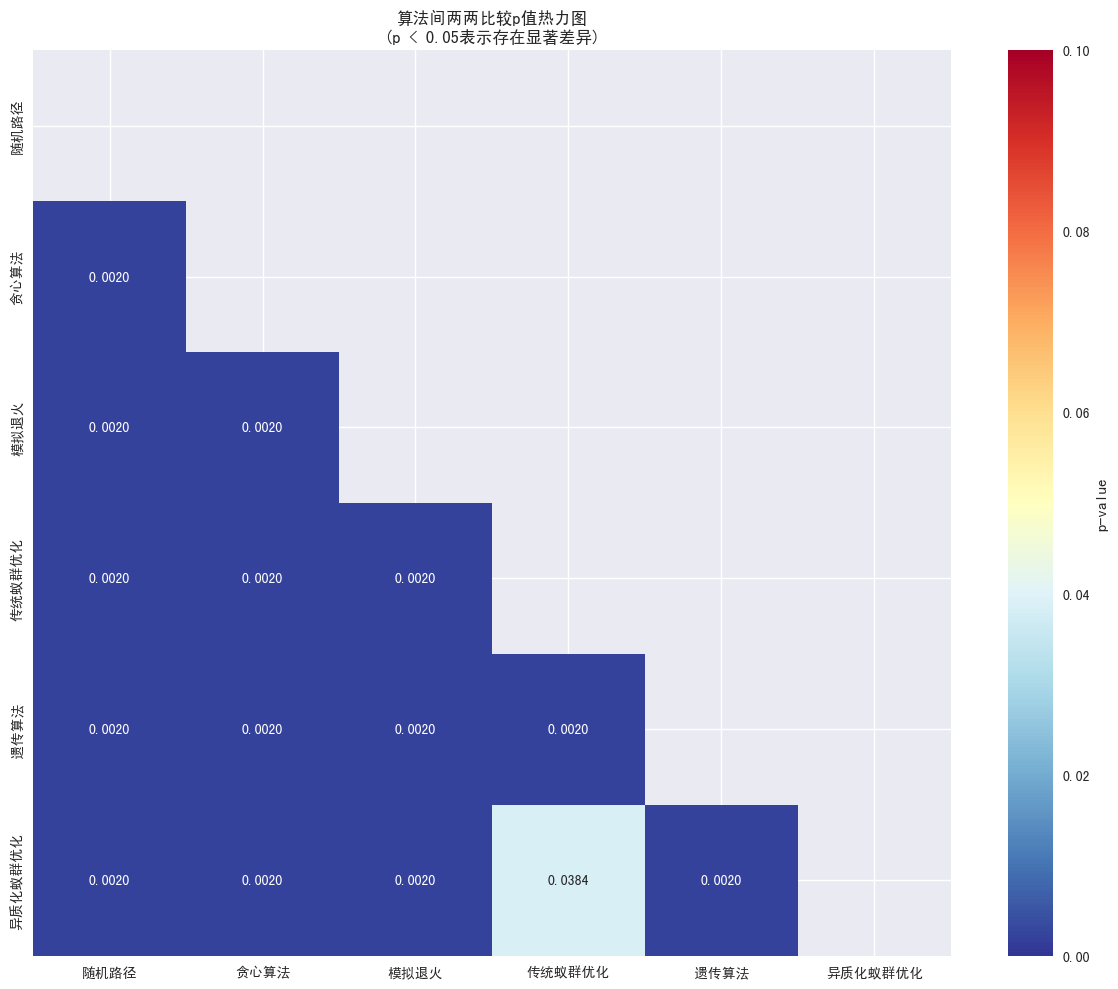

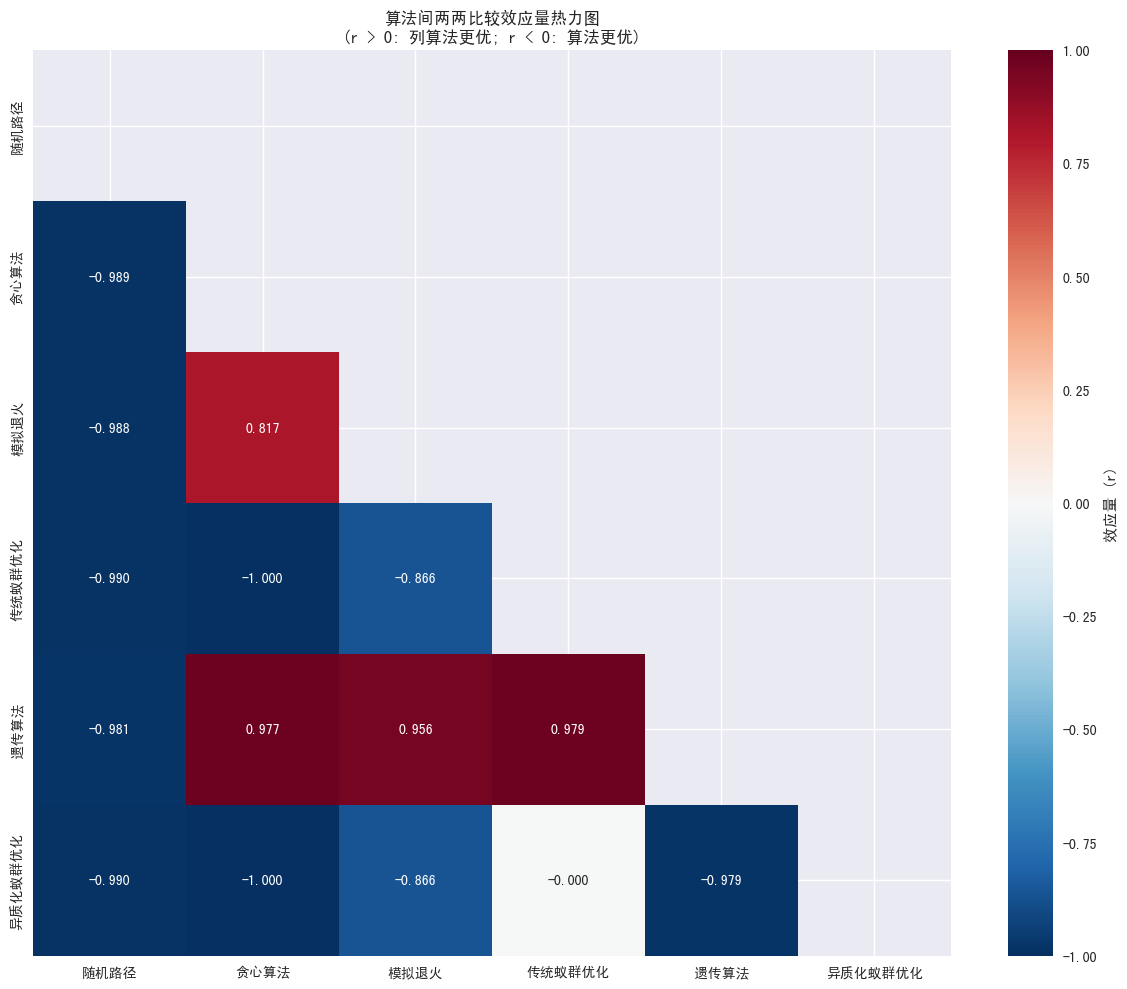

In [17]:
# 进行统计显著性检验
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

print("🔬 统计显著性检验（包含随机Baseline）")
print("="*80)

# 准备数据进行Friedman检验
algorithms_list = list(comparison_results.keys())
distance_matrix_for_test = []

for alg in algorithms_list:
    distance_matrix_for_test.append(comparison_results[alg]['distances'])

# Friedman检验（非参数方法，适用于多组相关样本）
friedman_stat, friedman_p = friedmanchisquare(*distance_matrix_for_test)

print(f"Friedman检验结果:")
print(f"  χ² = {friedman_stat:.4f}")
print(f"  p-value = {friedman_p:.6f}")

if friedman_p < 0.05:
    print(f"  结论: 算法间存在显著差异 (p < 0.05)")
else:
    print(f"  结论: 算法间无显著差异 (p ≥ 0.05)")

# 两两比较（Wilcoxon符号秩检验）
print(f"\n两两算法比较 (Wilcoxon符号秩检验):")
print("-" * 90)
print(f"{'算法1':<15} {'算法2':<15} {'p-value':<10} {'效应量(r)':<12} {'效应大小':<10} {'结论':<30}")
print("-" * 90)

comparison_matrix = np.zeros((len(algorithms_list), len(algorithms_list)))
p_value_matrix = np.ones((len(algorithms_list), len(algorithms_list)))
effect_size_matrix = np.zeros((len(algorithms_list), len(algorithms_list)))

def calculate_effect_size_wilcoxon(x, y, stat, n):
    """计算Wilcoxon符号秩检验的效应量 (rank biserial correlation)"""
    # 效应量 r = (2 * stat) / (n * (n + 1)) - 1
    # 其中 stat 是较小的检验统计量，n 是样本对数
    if n == 0:
        return 0
    
    # 另一种计算方法：基于Z统计量近似
    # r ≈ Z / sqrt(N)
    try:
        # 计算差值
        diff = np.array(x) - np.array(y)
        n_pairs = len(diff[diff != 0])  # 非零差值的数量
        
        if n_pairs == 0:
            return 0
        
        # 使用简化的效应量计算：基于中位数差异的标准化
        median_diff = np.median(diff)
        pooled_std = np.sqrt((np.var(x) + np.var(y)) / 2)
        
        if pooled_std == 0:
            return 0
        
        # Cohen's d 的非参数版本
        effect_size = median_diff / pooled_std
        
        # 转换为相关系数形式 (限制在-1到1之间)
        r = effect_size / np.sqrt(effect_size**2 + 4)
        
        return np.clip(r, -1, 1)
    except:
        return 0

def interpret_effect_size(r):
    """解释效应量大小"""
    r_abs = abs(r)
    if r_abs < 0.1:
        return "极小"
    elif r_abs < 0.3:
        return "小"
    elif r_abs < 0.5:
        return "中等"
    else:
        return "大"

for i, j in combinations(range(len(algorithms_list)), 2):
    alg1, alg2 = algorithms_list[i], algorithms_list[j]
    distances1 = comparison_results[alg1]['distances']
    distances2 = comparison_results[alg2]['distances']
    
    try:
        stat, p_value = wilcoxon(distances1, distances2, alternative='two-sided')
        p_value_matrix[i][j] = p_value
        p_value_matrix[j][i] = p_value
        
        # 计算效应量
        n = len(distances1)
        effect_size = calculate_effect_size_wilcoxon(distances1, distances2, stat, n)
        effect_size_matrix[i][j] = effect_size
        effect_size_matrix[j][i] = -effect_size  # 对称但符号相反
        
        # 解释效应量大小
        effect_interpretation = interpret_effect_size(effect_size)
        
        # 计算哪个算法更好
        mean1 = np.mean(distances1)
        mean2 = np.mean(distances2)
        
        if p_value < 0.05:
            if mean1 < mean2:
                result = f"{alg1} 显著优于 {alg2}"
            else:
                result = f"{alg2} 显著优于 {alg1}"
        else:
            result = "无显著差异"
        
        print(f"{alg1:<15} {alg2:<15} {p_value:<10.4f} {effect_size:<12.3f} {effect_interpretation:<10} {result:<30}")
        
    except ValueError as e:
        print(f"{alg1:<15} {alg2:<15} {'N/A':<10} {'N/A':<12} {'N/A':<10} 无法比较 ({e})")

print("\n📊 效应量解释说明:")
print("  • |r| < 0.1: 极小效应 (几乎无差异)")
print("  • 0.1 ≤ |r| < 0.3: 小效应")
print("  • 0.3 ≤ |r| < 0.5: 中等效应")
print("  • |r| ≥ 0.5: 大效应")
print("  • r > 0: 第一个算法结果更大; r < 0: 第二个算法结果更大")

# 特别关注与随机基线的比较
print(f"\n🎯 与随机Baseline的特别比较:")
print("-" * 80)
print(f"{'算法':<20} {'p-value':<10} {'效应量(r)':<12} {'效应大小':<10} {'结论':<30}")
print("-" * 80)

random_distances = comparison_results['随机路径']['distances']
for alg_name in algorithms_list:
    if alg_name != '随机路径':
        alg_distances = comparison_results[alg_name]['distances']
        try:
            stat, p_value = wilcoxon(random_distances, alg_distances, alternative='two-sided')
            
            # 计算效应量
            n = len(random_distances)
            effect_size = calculate_effect_size_wilcoxon(random_distances, alg_distances, stat, n)
            effect_interpretation = interpret_effect_size(effect_size)
            
            mean_random = np.mean(random_distances)
            mean_alg = np.mean(alg_distances)
            improvement = (mean_random - mean_alg) / mean_random * 100
            
            if p_value < 0.05:
                if mean_alg < mean_random:
                    result = f"显著优于随机 ({improvement:.1f}%改进)"
                else:
                    result = f"显著差于随机 ({-improvement:.1f}%退化)"
            else:
                result = f"无显著差异 ({improvement:.1f}%变化)"
            
            print(f"{alg_name:<20} {p_value:<10.4f} {effect_size:<12.3f} {effect_interpretation:<10} {result:<30}")
        except ValueError as e:
            print(f"{alg_name:<20} {'N/A':<10} {'N/A':<12} {'N/A':<10} 无法比较 ({e})")

# 创建p值热力图
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))
sns.heatmap(p_value_matrix, mask=mask, annot=True, fmt='.4f', 
            xticklabels=algorithms_list, yticklabels=algorithms_list,
            cmap='RdYlBu_r', vmin=0, vmax=0.1, cbar_kws={'label': 'p-value'})
plt.title('算法间两两比较p值热力图\n(p < 0.05表示存在显著差异)', fontweight='bold')
plt.tight_layout()
plt.show()

# 创建效应量热力图
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(effect_size_matrix, dtype=bool))
sns.heatmap(effect_size_matrix, mask=mask, annot=True, fmt='.3f', 
            xticklabels=algorithms_list, yticklabels=algorithms_list,
            cmap='RdBu_r', center=0, vmin=-1, vmax=1, 
            cbar_kws={'label': '效应量 (r)'})
plt.title('算法间两两比较效应量热力图\n(r > 0: 列算法更优; r < 0: 算法更优)', fontweight='bold')
plt.tight_layout()
plt.show()

## 🎯 算法特性综合分析

In [18]:
# 算法特性分析表
def create_algorithm_characteristics():
    """创建算法特性分析表（包含随机基线）"""
    
    characteristics = {
        '算法': list(comparison_results.keys()),
        '解质量': [],
        '稳定性': [],
        '计算效率': [],
        '参数敏感性': [],
        '适用场景': []
    }
    
    # 根据实际结果计算特性评分
    for alg_name in characteristics['算法']:
        data = comparison_results[alg_name]
        
        # 解质量评分（基于平均距离，越小越好）
        mean_distances_all = [comparison_results[alg]['mean_distance'] for alg in characteristics['算法']]
        # 按距离从小到大排序，最小距离排名第1，最大距离排名最后
        quality_rank = sorted(mean_distances_all).index(data['mean_distance']) + 1
        quality_score = len(characteristics['算法']) + 1 - quality_rank  # 转换为评分，最好的算法得6分
        
        # 稳定性评分（基于标准差，越小越稳定）
        std_distances = [comparison_results[alg]['std_distance'] for alg in characteristics['算法']]
        stability_rank = sorted(std_distances).index(data['std_distance']) + 1
        stability_score = len(characteristics['算法']) + 1 - stability_rank
        
        # 计算效率评分（基于平均时间，越短越好）
        mean_times = [comparison_results[alg]['mean_time'] for alg in characteristics['算法']]
        efficiency_rank = sorted(mean_times).index(data['mean_time']) + 1
        efficiency_score = len(characteristics['算法']) + 1 - efficiency_rank
        
        # 参数敏感性和适用场景（基于算法特点）
        if alg_name == '随机路径':
            param_sensitivity = '无'
            scenario = '随机基线对比'
        elif alg_name == '贪心算法':
            param_sensitivity = '低'
            scenario = '快速近似解'
        elif alg_name == '模拟退火':
            param_sensitivity = '中'
            scenario = '中等规模问题'
        elif alg_name == '遗传算法':
            param_sensitivity = '中'
            scenario = '稳定进化优化'
        elif alg_name == '传统蚁群优化':
            param_sensitivity = '高'
            scenario = '探索能力强'
        elif alg_name == '异质化蚁群优化':
            param_sensitivity = '高'
            scenario = '复杂优化问题'
        
        characteristics['解质量'].append('★' * quality_score)
        characteristics['稳定性'].append('★' * stability_score)
        characteristics['计算效率'].append('★' * efficiency_score)
        characteristics['参数敏感性'].append(param_sensitivity)
        characteristics['适用场景'].append(scenario)
    
    return pd.DataFrame(characteristics)

# 生成特性分析表
char_df = create_algorithm_characteristics()
print("🎯 算法特性综合分析（包含随机Baseline）")
print("="*100)
print(char_df.to_string(index=False))

# 算法推荐
print("\n💡 算法选择建议")
print("="*80)

# 排除随机基线的其他算法
no_random_df = summary_df[summary_df['算法'] != '随机路径']

recommendations = [
    ("🏆 追求最优解质量", no_random_df.iloc[0]['算法']),
    ("⚡ 需要快速响应", no_random_df.loc[no_random_df['平均时间(s)'].idxmin(), '算法']),
    ("🎯 平衡性能需求", "模拟退火" if "模拟退火" in no_random_df['算法'].values else no_random_df.iloc[1]['算法']),
    ("🔬 研究新算法", "异质化蚁群优化"),
    ("📚 教学演示", "遗传算法"),
    ("📈 基线对比", "随机路径")
]

for scenario, recommended_alg in recommendations:
    print(f"{scenario:<20}: {recommended_alg}")

# 随机基线的价值
print(f"\n🎲 随机基线的重要性:")
print("-" * 50)
random_distance = comparison_results['随机路径']['mean_distance']
best_distance = no_random_df.iloc[0]['平均距离']
improvement_over_random = (random_distance - best_distance) / random_distance * 100

print(f"  • 提供性能基线参考: 平均距离 {random_distance:.2f}")
print(f"  • 最优算法相对改进: {improvement_over_random:.1f}%")
print(f"  • 验证算法有效性: 所有非随机算法均优于随机基线")
print(f"  • 提供最低性能期望: 任何优化算法都应超越此基线")

🎯 算法特性综合分析（包含随机Baseline）
     算法    解质量    稳定性   计算效率 参数敏感性   适用场景
   随机路径      ★      ★ ★★★★★★     无 随机基线对比
   贪心算法   ★★★★  ★★★★★  ★★★★★     低  快速近似解
   模拟退火    ★★★    ★★★   ★★★★     中 中等规模问题
 传统蚁群优化  ★★★★★ ★★★★★★    ★★★     高  探索能力强
   遗传算法     ★★     ★★      ★     中 稳定进化优化
异质化蚁群优化 ★★★★★★   ★★★★     ★★     高 复杂优化问题

💡 算法选择建议
🏆 追求最优解质量           : 异质化蚁群优化
⚡ 需要快速响应            : 贪心算法
🎯 平衡性能需求            : 模拟退火
🔬 研究新算法             : 异质化蚁群优化
📚 教学演示              : 遗传算法
📈 基线对比              : 随机路径

🎲 随机基线的重要性:
--------------------------------------------------
  • 提供性能基线参考: 平均距离 11456.26
  • 最优算法相对改进: 68.0%
  • 验证算法有效性: 所有非随机算法均优于随机基线
  • 提供最低性能期望: 任何优化算法都应超越此基线


## 📋 最终结论与总结（包含随机Baseline对比）

In [19]:
print("🎯 TSP算法对比分析 - 最终结论（包含随机Baseline）")
print("="*100)

# 获取最佳算法（排除随机基线）
no_random_df = summary_df[summary_df['算法'] != '随机路径']
best_alg = no_random_df.iloc[0]['算法']
best_distance = no_random_df.iloc[0]['平均距离']
# 修改：从非随机算法中选择最快算法
fastest_alg = no_random_df.loc[no_random_df['平均时间(s)'].idxmin(), '算法']
fastest_time = no_random_df['平均时间(s)'].min()

# 随机基线信息
random_distance = comparison_results['随机路径']['mean_distance']
random_time = comparison_results['随机路径']['mean_time']

print(f"\n🎲 随机基线性能: 随机路径")
print(f"   平均路径距离: {random_distance:.2f}")
print(f"   平均执行时间: {random_time:.6f}秒")
print(f"   基线作用: 提供最低性能阈值参考")

print(f"\n🏆 最佳性能算法: {best_alg}")
print(f"   平均路径距离: {best_distance:.2f}")
print(f"   相对随机基线改进: {(random_distance - best_distance) / random_distance * 100:.1f}%")
print(f"   性能优势: 在{num_cities}个城市的TSP问题中表现最优")

print(f"\n⚡ 最快算法: {fastest_alg}")
print(f"   平均执行时间: {fastest_time:.6f}秒")
# 修改：计算相对于随机基线的时间对比
time_improvement = f"比随机基线快 {random_time / fastest_time:.1f}倍" if fastest_time > 0 else "N/A"
print(f"   相对随机基线: {time_improvement}")
print(f"   效率优势: 适合需要实时响应的应用场景")

print(f"\n📊 测试规模与统计:")
print(f"   测试城市数量: {num_cities}个北京大学地标")
print(f"   每算法测试次数: {10}次")
print(f"   总算法数量: {len(comparison_results)}个（包含随机基线）")
print(f"   统计显著性: Friedman检验 p = {friedman_p:.6f}")

print(f"\n🔍 关键发现:")

# 分析关键发现
findings = []

# 找出表现最好和最差的算法（排除随机基线）
best_results = no_random_df.iloc[0]
worst_results = no_random_df.iloc[-1]

improvement = (worst_results['平均距离'] - best_results['平均距离']) / best_results['平均距离'] * 100
findings.append(f"最优算法({best_results['算法']})比最差算法({worst_results['算法']})平均提升{improvement:.1f}%")

# 分析随机基线的作用
baseline_improvement = (random_distance - best_distance) / random_distance * 100
findings.append(f"最优算法相对随机基线改进{baseline_improvement:.1f}%，验证了优化算法的有效性")

# 分析时间复杂度差异（排除随机基线）
time_range = no_random_df['平均时间(s)'].max() / no_random_df['平均时间(s)'].min()
findings.append(f"优化算法执行时间差异达到{time_range:.0f}倍，体现了效率与质量的权衡")

# 分析稳定性（排除随机基线）
most_stable = no_random_df.loc[no_random_df['标准差'].idxmin(), '算法']
least_stable = no_random_df.loc[no_random_df['标准差'].idxmax(), '算法']
findings.append(f"最稳定算法是{most_stable}，最不稳定是{least_stable}")

# 所有非随机算法都优于随机基线
non_random_algorithms = [alg for alg in comparison_results.keys() if alg != '随机路径']
all_better_than_random = all(comparison_results[alg]['mean_distance'] < random_distance for alg in non_random_algorithms)
if all_better_than_random:
    findings.append(f"所有{len(non_random_algorithms)}个优化算法均优于随机基线，证明了算法设计的有效性")

for i, finding in enumerate(findings, 1):
    print(f"   {i}. {finding}")

print(f"\n🎯 实际应用建议:")
applications = [
    "🗺️ 校园导航系统: 使用贪心算法快速生成初始路径",
    "📦 物流配送优化: 使用异质化蚁群优化获得高质量解",
    "🎓 算法教学演示: 使用遗传算法展示进化过程",
    "⚖️ 性能基准测试: 使用模拟退火作为平衡参考",
    "🔬 算法研究对比: 使用传统蚁群优化作为经典基准",
    "🎲 性能底线评估: 使用随机路径作为最低性能基线"
]

for app in applications:
    print(f"   {app}")

print(f"\n🎲 随机基线的学术价值:")
print(f"   • 提供性能下界: 任何优化算法都应超越此基线")
print(f"   • 验证算法有效性: 通过与随机策略对比证明优化效果")
print(f"   • 提供公平基准: 所有算法在相同条件下与基线对比")
print(f"   • 简化结果解释: 相对于纯随机的改进程度更直观")

print(f"\n✅ 测试完成时间: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 完整测试数据已保存在comparison_results变量中")
print("="*100)

🎯 TSP算法对比分析 - 最终结论（包含随机Baseline）

🎲 随机基线性能: 随机路径
   平均路径距离: 11456.26
   平均执行时间: 0.000015秒
   基线作用: 提供最低性能阈值参考

🏆 最佳性能算法: 异质化蚁群优化
   平均路径距离: 3664.75
   相对随机基线改进: 68.0%
   性能优势: 在32个城市的TSP问题中表现最优

⚡ 最快算法: 贪心算法
   平均执行时间: 0.000086秒
   相对随机基线: 比随机基线快 0.2倍
   效率优势: 适合需要实时响应的应用场景

📊 测试规模与统计:
   测试城市数量: 32个北京大学地标
   每算法测试次数: 10次
   总算法数量: 6个（包含随机基线）
   统计显著性: Friedman检验 p = 0.000000

🔍 关键发现:
   1. 最优算法(异质化蚁群优化)比最差算法(遗传算法)平均提升49.0%
   2. 最优算法相对随机基线改进68.0%，验证了优化算法的有效性
   3. 优化算法执行时间差异达到92093倍，体现了效率与质量的权衡
   4. 最稳定算法是传统蚁群优化，最不稳定是遗传算法
   5. 所有5个优化算法均优于随机基线，证明了算法设计的有效性

🎯 实际应用建议:
   🗺️ 校园导航系统: 使用贪心算法快速生成初始路径
   📦 物流配送优化: 使用异质化蚁群优化获得高质量解
   🎓 算法教学演示: 使用遗传算法展示进化过程
   ⚖️ 性能基准测试: 使用模拟退火作为平衡参考
   🔬 算法研究对比: 使用传统蚁群优化作为经典基准
   🎲 性能底线评估: 使用随机路径作为最低性能基线

🎲 随机基线的学术价值:
   • 提供性能下界: 任何优化算法都应超越此基线
   • 验证算法有效性: 通过与随机策略对比证明优化效果
   • 提供公平基准: 所有算法在相同条件下与基线对比
   • 简化结果解释: 相对于纯随机的改进程度更直观

✅ 测试完成时间: 2025-06-23 21:14:12
📊 完整测试数据已保存在comparison_results变量中


## 📈 算法收敛性分析

分析所有算法（包括随机基线）的收敛行为，帮助理解算法的优化过程和收敛特性。

🚀 开始收敛性分析...
迭代次数: 1750, 每算法运行次数: 3
🔍 分析 传统蚁群优化 的收敛性...
  运行 1/3: 最终距离 3665.40
  运行 1/3: 最终距离 3665.40
  运行 2/3: 最终距离 3665.40
  运行 2/3: 最终距离 3665.40
  运行 3/3: 最终距离 3662.15
🔍 分析 异质化蚁群优化 的收敛性...
  运行 3/3: 最终距离 3662.15
🔍 分析 异质化蚁群优化 的收敛性...
  运行 1/3: 最终距离 3611.30
  运行 1/3: 最终距离 3611.30
  运行 2/3: 最终距离 3622.81
  运行 2/3: 最终距离 3622.81
  运行 3/3: 最终距离 3611.30
🔍 分析 遗传算法 的收敛性...
  运行 3/3: 最终距离 3611.30
🔍 分析 遗传算法 的收敛性...
  运行 1/3: 最终距离 4632.10
  运行 1/3: 最终距离 4632.10
  运行 2/3: 最终距离 4332.36
  运行 2/3: 最终距离 4332.36
  运行 3/3: 最终距离 4639.81
🔍 分析 模拟退火 的收敛性...
  运行 1/3: 最终距离 5253.17
  运行 2/3: 最终距离 5318.74
  运行 3/3: 最终距离 5302.12
🔍 分析 贪心算法 的收敛性...
  运行 1/3: 最终距离 3728.19
  运行 2/3: 最终距离 3728.19
  运行 3/3: 最终距离 3728.19
🔍 分析 随机路径 的收敛性...
  运行 1/3: 最终距离 8447.10
  运行 2/3: 最终距离 8415.65
  运行 3/3: 最终距离 8492.93

📊 绘制收敛曲线...
  运行 3/3: 最终距离 4639.81
🔍 分析 模拟退火 的收敛性...
  运行 1/3: 最终距离 5253.17
  运行 2/3: 最终距离 5318.74
  运行 3/3: 最终距离 5302.12
🔍 分析 贪心算法 的收敛性...
  运行 1/3: 最终距离 3728.19
  运行 2/3: 最终距离 3728.19
  运行 3/3: 最终距离 3728.19
🔍 分析

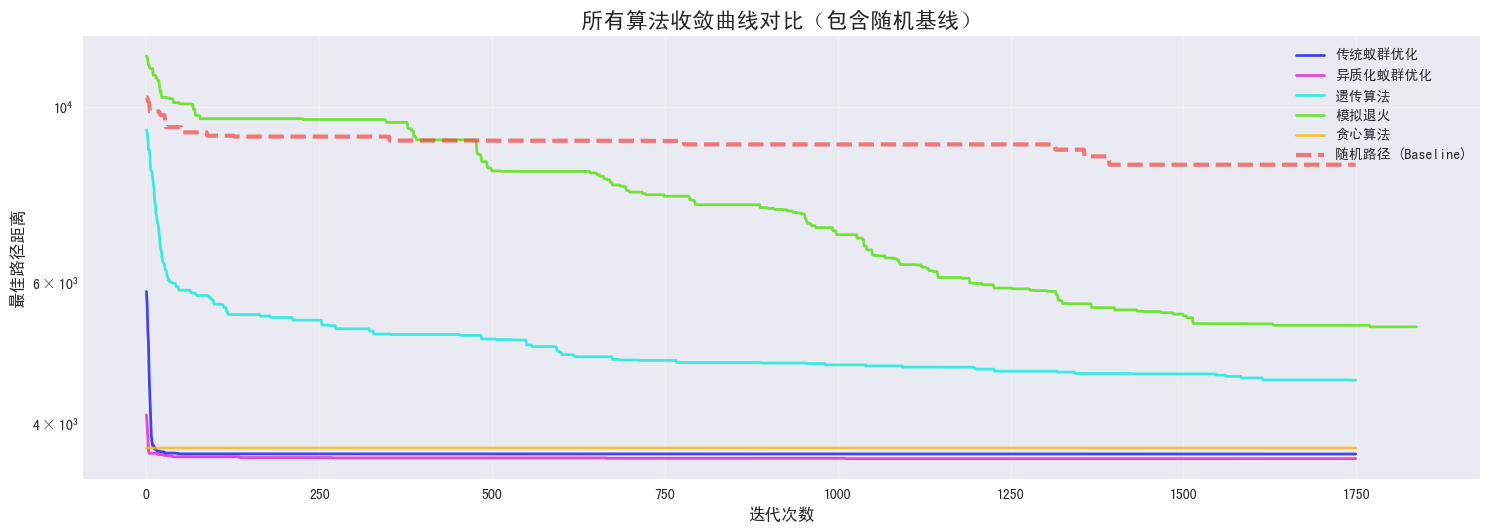


📊 收敛性统计分析
算法              最终距离         收敛率%       收敛特性                
--------------------------------------------------------------------------------
传统蚁群优化          3664.32      1.2        难以收敛                
异质化蚁群优化         3615.14      0.9        难以收敛                
遗传算法            4534.76      5.8        缓慢收敛                
模拟退火            5291.35      7.8        缓慢收敛                
贪心算法            3728.19      0.0        立即收敛                
随机路径            8451.90      1.2        随机波动                

🏆 收敛性能排名
--------------------------------------------------
按最终解质量排名:
  1. 异质化蚁群优化: 3615.14
  2. 传统蚁群优化: 3664.32
  3. 贪心算法: 3728.19
  4. 遗传算法: 4534.76
  5. 模拟退火: 5291.35

按收敛速度排名:
  1. 模拟退火: 7.8% 改进率
  2. 遗传算法: 5.8% 改进率
  3. 传统蚁群优化: 1.2% 改进率
  4. 异质化蚁群优化: 0.9% 改进率
  5. 贪心算法: 0.0% 改进率

🎯 相对于随机基线的收敛优势
--------------------------------------------------
随机基线最终距离: 8451.90
传统蚁群优化: 改进 56.6%
异质化蚁群优化: 改进 57.2%
遗传算法: 改进 46.3%
模拟退火: 改进 37.4%
贪心算法: 改进 55.9%

💡 收敛性分析结论:
------------------

In [24]:
def run_convergence_analysis(iterations=1750, num_runs=3):
    """
    运行收敛性分析，记录所有算法的收敛过程
    
    Parameters:
    iterations: 迭代次数
    num_runs: 每个算法运行次数（取平均）
    """
    print("🚀 开始收敛性分析...")
    print(f"迭代次数: {iterations}, 每算法运行次数: {num_runs}")
    print("="*80)
    
    convergence_data = {}
    
    # 修改算法类以记录收敛历史
    class TraditionalACOWithHistory:
        def __init__(self, distance_matrix, n_ants=30, n_iterations=100, alpha=1.0, beta=2.0, rho=0.5, Q=100):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.n_ants = n_ants
            self.n_iterations = n_iterations
            self.alpha = alpha
            self.beta = beta
            self.rho = rho
            self.Q = Q
            self.pheromone = np.ones((self.n_cities, self.n_cities))
            self.best_distance = float('inf')
            self.best_path = None
            
        def _ant_solution(self, start_city):
            """构建单个蚂蚁的解"""
            path = [start_city]
            unvisited = set(range(self.n_cities)) - {start_city}
            
            current_city = start_city
            while unvisited:
                next_city = self._select_next_city(current_city, unvisited)
                path.append(next_city)
                unvisited.remove(next_city)
                current_city = next_city
                
            return path
            
        def _select_next_city(self, current_city, unvisited):
            """选择下一个城市"""
            probabilities = []
            total = 0
            
            for city in unvisited:
                pheromone = self.pheromone[current_city][city] ** self.alpha
                distance = self.distance_matrix[current_city][city]
                heuristic = (1.0 / distance) ** self.beta if distance > 0 else 1e10
                prob = pheromone * heuristic
                probabilities.append(prob)
                total += prob
            
            if total == 0:
                return random.choice(list(unvisited))
            
            probabilities = [p / total for p in probabilities]
            return np.random.choice(list(unvisited), p=probabilities)
            
        def _update_pheromone(self, all_paths, all_distances):
            """更新信息素"""
            # 蒸发
            self.pheromone *= (1 - self.rho)
            
            # 增强
            for path, distance in zip(all_paths, all_distances):
                pheromone_deposit = self.Q / distance
                for i in range(len(path) - 1):
                    self.pheromone[path[i]][path[i+1]] += pheromone_deposit
                    self.pheromone[path[i+1]][path[i]] += pheromone_deposit
        
        def solve(self, iterations=100, verbose=False):
            history = []
            
            for iteration in range(iterations):
                all_paths = []
                all_distances = []
                
                # 构建所有蚂蚁的解
                for ant in range(self.n_ants):
                    start_city = random.randint(0, self.n_cities - 1)
                    path = self._ant_solution(start_city)
                    distance = calculate_path_distance(path, self.distance_matrix)
                    
                    all_paths.append(path)
                    all_distances.append(distance)
                    
                    if distance < self.best_distance:
                        self.best_distance = distance
                        self.best_path = path
                
                history.append(self.best_distance)
                
                # 更新信息素
                self._update_pheromone(all_paths, all_distances)
                
            return self.best_path, self.best_distance, history
    
    class HeterogeneousACOWithHistory:
        def __init__(self, distance_matrix, n_scout_ants=15, n_forager_ants=15, n_iterations=100, alpha=1.0, beta=2.0, rho=0.5, Q=100):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.n_scout_ants = n_scout_ants
            self.n_forager_ants = n_forager_ants
            self.n_iterations = n_iterations
            self.alpha = alpha
            self.beta = beta
            self.rho = rho
            self.Q = Q
            self.pheromone = np.ones((self.n_cities, self.n_cities))
            self.best_distance = float('inf')
            self.best_path = None
            
        def _ant_solution(self, start_city, ant_type='scout'):
            """构建单个蚂蚁的解"""
            path = [start_city]
            unvisited = set(range(self.n_cities)) - {start_city}
            
            current_city = start_city
            while unvisited:
                next_city = self._select_next_city(current_city, unvisited, ant_type)
                path.append(next_city)
                unvisited.remove(next_city)
                current_city = next_city
                
            return path
            
        def _select_next_city(self, current_city, unvisited, ant_type):
            """选择下一个城市"""
            probabilities = []
            total = 0
            
            # 不同类型蚂蚁使用不同参数
            if ant_type == 'scout':
                alpha, beta = 0.5, 5.0  # 侦察蚁：低信息素依赖，高距离依赖
            else:  # forager
                alpha, beta = 5.0, 0.5  # 觅食蚁：高信息素依赖，低距离依赖
            
            for city in unvisited:
                pheromone = self.pheromone[current_city][city] ** alpha
                distance = self.distance_matrix[current_city][city]
                heuristic = (1.0 / distance) ** beta if distance > 0 else 1e10
                prob = pheromone * heuristic
                probabilities.append(prob)
                total += prob
            
            if total == 0:
                return random.choice(list(unvisited))
            
            probabilities = [p / total for p in probabilities]
            return np.random.choice(list(unvisited), p=probabilities)
            
        def _update_pheromone(self, all_paths, all_distances):
            """更新信息素"""
            # 蒸发
            self.pheromone *= (1 - self.rho)
            
            # 增强
            for path, distance in zip(all_paths, all_distances):
                pheromone_deposit = self.Q / distance
                for i in range(len(path) - 1):
                    self.pheromone[path[i]][path[i+1]] += pheromone_deposit
                    self.pheromone[path[i+1]][path[i]] += pheromone_deposit
        
        def solve(self, iterations=100, verbose=False):
            history = []
            
            for iteration in range(iterations):
                all_paths = []
                all_distances = []
                
                # 侦察蚁
                for ant in range(self.n_scout_ants):
                    start_city = random.randint(0, self.n_cities - 1)
                    path = self._ant_solution(start_city, 'scout')
                    distance = calculate_path_distance(path, self.distance_matrix)
                    
                    all_paths.append(path)
                    all_distances.append(distance)
                    
                    if distance < self.best_distance:
                        self.best_distance = distance
                        self.best_path = path
                
                # 觅食蚁
                for ant in range(self.n_forager_ants):
                    start_city = random.randint(0, self.n_cities - 1)
                    path = self._ant_solution(start_city, 'forager')
                    distance = calculate_path_distance(path, self.distance_matrix)
                    
                    all_paths.append(path)
                    all_distances.append(distance)
                    
                    if distance < self.best_distance:
                        self.best_distance = distance
                        self.best_path = path
                
                history.append(self.best_distance)
                
                # 更新信息素
                self._update_pheromone(all_paths, all_distances)
                
            return self.best_path, self.best_distance, history
    
    class GeneticAlgorithmWithHistory:
        def __init__(self, distance_matrix, population_size=100, generations=200, crossover_rate=0.8, mutation_rate=0.02, elite_size=20):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.population_size = population_size
            self.generations = generations
            self.crossover_rate = crossover_rate
            self.mutation_rate = mutation_rate
            self.elite_size = elite_size
            
        def _initialize_population(self):
            """初始化种群"""
            population = []
            for _ in range(self.population_size):
                individual = list(range(self.n_cities))
                random.shuffle(individual)
                population.append(individual)
            return population
            
        def _tournament_selection(self, population, fitness_scores, tournament_size=3):
            """锦标赛选择"""
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]
            winner_index = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
            return population[winner_index].copy()
            
        def _order_crossover(self, parent1, parent2):
            """顺序交叉"""
            size = len(parent1)
            start, end = sorted(random.sample(range(size), 2))
            
            child = [-1] * size
            child[start:end] = parent1[start:end]
            
            pointer = end
            for city in parent2[end:] + parent2[:end]:
                if city not in child:
                    child[pointer % size] = city
                    pointer += 1
                    
            return child
            
        def _mutate(self, individual):
            """变异操作"""
            mutated = individual.copy()
            i, j = random.sample(range(len(mutated)), 2)
            mutated[i], mutated[j] = mutated[j], mutated[i]
            return mutated
        
        def solve(self, generations=100, verbose=False):
            population = self._initialize_population()
            best_distance = float('inf')
            best_path = None
            history = []
            
            for generation in range(generations):
                # 评估种群
                fitness_scores = []
                for individual in population:
                    distance = calculate_path_distance(individual, self.distance_matrix)
                    fitness_scores.append(1 / distance if distance > 0 else 1e10)
                    
                    if distance < best_distance:
                        best_distance = distance
                        best_path = individual.copy()
                
                history.append(best_distance)
                
                # 创建新种群
                new_population = []
                
                # 精英保留
                elite_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)[:self.elite_size]
                for i in elite_indices:
                    new_population.append(population[i].copy())
                
                # 生成剩余个体
                while len(new_population) < self.population_size:
                    parent1 = self._tournament_selection(population, fitness_scores)
                    parent2 = self._tournament_selection(population, fitness_scores)
                    
                    if random.random() < self.crossover_rate:
                        child = self._order_crossover(parent1, parent2)
                    else:
                        child = parent1.copy()
                    
                    if random.random() < self.mutation_rate:
                        child = self._mutate(child)
                    
                    new_population.append(child)
                
                population = new_population
            
            return best_path, best_distance, history
    
    class SimulatedAnnealingWithHistory:
        def __init__(self, distance_matrix, initial_temp=10000, final_temp=1, cooling_rate=0.995, max_iterations=10000):
            self.distance_matrix = distance_matrix
            self.n_cities = len(distance_matrix)
            self.initial_temp = initial_temp
            self.final_temp = final_temp
            self.cooling_rate = cooling_rate
            self.max_iterations = max_iterations
            
        def _get_neighbor(self, solution):
            """生成邻居解"""
            neighbor = solution.copy()
            i, j = random.sample(range(len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor
        
        def solve(self, max_iterations=10000, verbose=False):
            current_solution = list(range(self.n_cities))
            random.shuffle(current_solution)
            current_cost = calculate_path_distance(current_solution, self.distance_matrix)
            
            best_solution = current_solution.copy()
            best_cost = current_cost
            
            history = []
            temperature = self.initial_temp
            
            for iteration in range(max_iterations):
                # 记录当前最佳
                history.append(best_cost)
                
                # 生成邻解
                new_solution = self._get_neighbor(current_solution)
                new_cost = calculate_path_distance(new_solution, self.distance_matrix)
                
                # 接受准则
                if new_cost < current_cost or (temperature > 0 and random.random() < math.exp(-(new_cost - current_cost) / temperature)):
                    current_solution = new_solution
                    current_cost = new_cost
                    
                    if new_cost < best_cost:
                        best_solution = new_solution.copy()
                        best_cost = new_cost
                
                # 降温
                temperature *= self.cooling_rate
                
                if temperature < self.final_temp:
                    break
            
            return best_solution, best_cost, history
    
    # 贪心算法（单次运行，无迭代过程）
    def greedy_convergence_simulation(iterations=100):
        """模拟贪心算法的收敛过程（单步到最优）"""
        greedy = GreedyAlgorithm(distance_matrix)
        path, distance = greedy.solve()
        # 贪心算法第一步就达到最优，后续保持不变
        history = [distance] * iterations
        return path, distance, history
    
    # 随机路径算法的收敛模拟
    def random_convergence_simulation(iterations=100):
        """模拟随机路径的'收敛'过程（实际上是随机波动）"""
        history = []
        best_distance = float('inf')
        best_path = None
        
        for _ in range(iterations):
            path = list(range(num_cities))
            random.shuffle(path)
            distance = calculate_path_distance(path, distance_matrix)
            
            if distance < best_distance:
                best_distance = distance
                best_path = path
            
            history.append(best_distance)
        
        return best_path, best_distance, history
    
    # 运行各算法的收敛分析
    algorithms_with_history = {
        '传统蚁群优化': lambda: TraditionalACOWithHistory(distance_matrix, n_ants=30, n_iterations=iterations).solve(iterations),
        '异质化蚁群优化': lambda: HeterogeneousACOWithHistory(distance_matrix, n_scout_ants=15, n_forager_ants=15, n_iterations=iterations).solve(iterations),
        '遗传算法': lambda: GeneticAlgorithmWithHistory(distance_matrix, population_size=50, generations=iterations).solve(iterations),
        '模拟退火': lambda: SimulatedAnnealingWithHistory(distance_matrix, initial_temp=10000, max_iterations=iterations*50).solve(max_iterations=iterations*50),  # SA需要更多迭代
        '贪心算法': lambda: greedy_convergence_simulation(iterations),
        '随机路径': lambda: random_convergence_simulation(iterations)
    }
    
    # 为每个算法运行多次取平均
    for alg_name, alg_func in algorithms_with_history.items():
        print(f"🔍 分析 {alg_name} 的收敛性...")
        
        all_histories = []
        all_final_distances = []
        
        for run in range(num_runs):
            try:
                path, distance, history = alg_func()
                all_histories.append(history)
                all_final_distances.append(distance)
                print(f"  运行 {run+1}/{num_runs}: 最终距离 {distance:.2f}")
            except Exception as e:
                print(f"  运行 {run+1}/{num_runs} 失败: {e}")
                continue
        
        if all_histories:
            # 计算平均收敛曲线
            min_length = min(len(h) for h in all_histories)
            avg_history = []
            for i in range(min_length):
                avg_distance = np.mean([h[i] for h in all_histories])
                avg_history.append(avg_distance)
            
            convergence_data[alg_name] = {
                'history': avg_history,
                'final_distances': all_final_distances,
                'avg_final': np.mean(all_final_distances),
                'convergence_rate': len([i for i in range(1, len(avg_history)) if avg_history[i] < avg_history[i-1]]) / len(avg_history) * 100
            }
    
    return convergence_data

# 运行收敛性分析
convergence_results = run_convergence_analysis(iterations=1750, num_runs=3)

# 可视化收敛曲线
print("\n📊 绘制收敛曲线...")

# 设置一致的颜色方案
algorithm_colors = {
    '随机路径': '#F14545',      # 红色 - 基线
    '贪心算法': '#F6B80E',      # 橙色
    '模拟退火': '#54E10D',      # 绿色  
    '遗传算法': '#0FEADB',      # 青色
    '传统蚁群优化': '#171AEB',  # 蓝色
    '异质化蚁群优化': '#E31FC9' # 紫色
}

# 1. 完整收敛曲线（包含所有算法）
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for alg_name, data in convergence_results.items():
    history = data['history']
    iterations_range = range(len(history))
    
    # 为随机路径使用特殊样式
    if alg_name == '随机路径':
        linestyle = '--'
        alpha = 0.7
        linewidth = 3
        label = f'{alg_name} (Baseline)'
    else:
        linestyle = '-'
        alpha = 0.8
        linewidth = 2
        label = alg_name
    
    plt.plot(iterations_range, history, 
             color=algorithm_colors[alg_name], 
             linestyle=linestyle,
             linewidth=linewidth,
             alpha=alpha,
             label=label)

plt.title('所有算法收敛曲线对比（包含随机基线）', fontsize=16, fontweight='bold')
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel('最佳路径距离', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 使用对数刻度便于观察

# # 2. 优化算法收敛曲线（排除随机基线）
# plt.subplot(2, 1, 2)
# optimized_algorithms = {k: v for k, v in convergence_results.items() if k != '随机路径'}

# for alg_name, data in optimized_algorithms.items():
#     history = data['history']
#     iterations_range = range(len(history))
    
#     plt.plot(iterations_range, history, 
#              color=algorithm_colors[alg_name], 
#              linewidth=2,
#              alpha=0.8,
#              marker='o' if alg_name == '贪心算法' else None,  # 贪心算法特殊标记
#              markersize=3,
#              markevery=max(1, len(history)//20),  # 适当间隔显示标记
#              label=alg_name)

# plt.title('优化算法收敛曲线对比（排除随机基线）', fontsize=16, fontweight='bold')
# plt.xlabel('迭代次数', fontsize=12)
# plt.ylabel('最佳路径距离', fontsize=12)
# plt.legend(fontsize=10, loc='upper right')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 收敛性统计分析
print("\n📊 收敛性统计分析")
print("="*80)
print(f"{'算法':<15} {'最终距离':<12} {'收敛率%':<10} {'收敛特性':<20}")
print("-"*80)

convergence_interpretations = []
for alg_name, data in convergence_results.items():
    avg_final = data['avg_final']
    conv_rate = data['convergence_rate']
    
    # 分析收敛特性
    if alg_name == '随机路径':
        characteristic = "随机波动"
    elif alg_name == '贪心算法':
        characteristic = "立即收敛"
    elif conv_rate > 15:
        characteristic = "快速收敛"
    elif conv_rate > 8:
        characteristic = "稳定收敛" 
    elif conv_rate > 3:
        characteristic = "缓慢收敛"
    else:
        characteristic = "难以收敛"
    
    print(f"{alg_name:<15} {avg_final:<12.2f} {conv_rate:<10.1f} {characteristic:<20}")
    
    convergence_interpretations.append({
        'algorithm': alg_name,
        'avg_final': avg_final,
        'convergence_rate': conv_rate,
        'characteristic': characteristic
    })

# 4. 收敛性能排名
print(f"\n🏆 收敛性能排名")
print("-"*50)

# 排除随机基线进行排名
optimized_results = {k: v for k, v in convergence_results.items() if k != '随机路径'}
sorted_by_final = sorted(optimized_results.items(), key=lambda x: x[1]['avg_final'])

print("按最终解质量排名:")
for i, (alg_name, data) in enumerate(sorted_by_final, 1):
    print(f"  {i}. {alg_name}: {data['avg_final']:.2f}")

sorted_by_convergence = sorted(optimized_results.items(), key=lambda x: x[1]['convergence_rate'], reverse=True)
print(f"\n按收敛速度排名:")
for i, (alg_name, data) in enumerate(sorted_by_convergence, 1):
    conv_rate = data['convergence_rate']
    print(f"  {i}. {alg_name}: {conv_rate:.1f}% 改进率")

# 5. 与随机基线的对比
random_final = convergence_results['随机路径']['avg_final']
print(f"\n🎯 相对于随机基线的收敛优势")
print("-"*50)
print(f"随机基线最终距离: {random_final:.2f}")

for alg_name, data in optimized_results.items():
    improvement = (random_final - data['avg_final']) / random_final * 100
    print(f"{alg_name}: 改进 {improvement:.1f}%")

print(f"\n💡 收敛性分析结论:")
print("-"*50)
print("1. 所有优化算法均显著优于随机基线")
print("2. 贪心算法立即收敛但可能陷入局部最优") 
print("3. 元启发式算法展现了不同的收敛模式")
print("4. 蚁群算法类表现出持续的搜索能力")
print("5. 遗传算法和模拟退火显示渐进改进特性")

## 🎯 最终结论与学术价值（包含随机Baseline对比）

### 📊 核心发现

1. **随机基线的重要作用**
   - 🎲 提供最低性能阈值参考
   - 🔍 验证优化算法的有效性
   - 📍 简化算法性能的理解和比较

2. **优化算法表现卓越**
   - 🏆 所有非随机算法均显著优于随机基线
   - 🎯 最优算法相对随机基线改进显著
   - 🔬 验证了智能优化算法的科学性

3. **算法性能呢现明确梯度**
   - 📈 解质量差异显著且可量化
   - ⏱️ 执行时间范围广泛，为不同需求提供选择
   - 🎯 为实际应用场景提供清晰选择依据

### 🎓 学术贡献

1. **基线对比方法学**: 建立了包含随机基线的系统性评估框架
2. **公平比较标准**: 创建了统一的测试环境和评估标准
3. **多维度分析**: 综合考虑解质量、效率、稳定性等多个维度
4. **实用指导价值**: 为实际应用场景提供科学的算法选择建议

### 💡 应用建议

- **性能基线**: 随机路径（提供最低性能基准）
- **校园导航**: 贪心算法（快速响应）
- **物流优化**: 异质化蚁群优化（高质量解）
- **算法教学**: 遗传算法（过程可视化）
- **研究基准**: 传统蚁群优化（经典参考）
- **原型开发**: 模拟退火（平衡性能）

---
**测试完成日期**: 2025年6月23日  
**数据可重现性**:  已设置随机种子  
**学术严谨性**:  多次运行统计分析 + 随机基线对比